# XGBoost and RF on Clustered Station Data

In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
import plotly.express as px
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
bike_changes_cluster_aggregated = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/bike_changes_cluster_aggregated.csv', low_memory=False)

In [4]:
df = bike_changes_cluster_aggregated.sort_values(['geo_cluster', 'time_interval'])
df.head(5)

,geo_cluster,time_interval,cumulative_bikes,hour,day_of_week,is_morning_rush,is_evening_rush,avg_trip_duration,median_trip_duration,electric_bike_count,...,windspeed,is_raining,station_count,cumulative_bikes_lag1,cumulative_bikes_lag2,cumulative_bikes_lag4,rate_of_change,rate_of_change_lag1,rolling_mean_4,rolling_std_4
0,0,2024-08-01 08:00:00,9,8,3,1,0,10.706667,8.900000,13.0,...,4.6,0,5,NaN,NaN,NaN,NaN,NaN,9.000000,NaN
1,0,2024-08-01 08:15:00,18,8,3,1,0,10.300000,10.300000,9.0,...,4.6,0,10,9.0,NaN,NaN,1.000000,NaN,13.500000,6.363961
2,0,2024-08-01 08:30:00,16,8,3,1,0,11.118056,10.270833,28.0,...,4.6,0,12,18.0,9.0,NaN,-0.111111,1.000000,14.333333,4.725816
3,0,2024-08-01 08:45:00,18,8,3,1,0,9.452778,9.437500,26.0,...,4.6,0,12,16.0,18.0,NaN,0.125000,-0.111111,15.250000,4.272002
4,0,2024-08-01 09:00:00,33,9,3,1,0,11.778125,12.046875,24.0,...,0.5,0,16,18.0,16.0,9.0,0.833333,0.125000,21.250000,7.889867


In [5]:
# ============================================================
# LOAD BEST SAVED XGBOOST MODEL FROM xgboost_rf.ipynb
# ============================================================
import joblib
import warnings
warnings.filterwarnings('ignore')

# Load the RandomizedSearchCV results
xgb_search = joblib.load('/content/drive/MyDrive/Colab Notebooks/xgboost_search_results.pkl')

# Extract the best model
best_xgb_model = xgb_search.best_estimator_

print("✅ Loaded XGBoost model from xgboost_search_results.pkl")
print("\nBest Parameters from Hyperparameter Search:")
for param, value in xgb_search.best_params_.items():
    print(f"  {param}: {value}")
print(f"\nBest CV Score (neg MSE): {xgb_search.best_score_:.4f}")
print(f"Best CV RMSE: {(-xgb_search.best_score_)**0.5:.4f}")

✅ Loaded XGBoost model from xgboost_search_results.pkl

Best Parameters from Hyperparameter Search:
  subsample: 0.6
  reg_lambda: 1.5
  reg_alpha: 0
  n_estimators: 300
  min_child_weight: 1
  max_depth: 9
  learning_rate: 0.05
  gamma: 0.3
  colsample_bytree: 1.0

Best CV Score (neg MSE): -46.9924
Best CV RMSE: 6.8551


## Data Preparation and Cleaning

In [6]:
print("=== FIXING BIKE_CHANGES_CLUSTER_AGGREGATED (Before Split) ===\n")

print(f"Initial shape: {bike_changes_cluster_aggregated.shape}")

# Check for problematic values
print("\nChecking for inf/NaN:")
for col in bike_changes_cluster_aggregated.columns:
    if bike_changes_cluster_aggregated[col].dtype in ['float64', 'float32']:
        inf_count = np.isinf(bike_changes_cluster_aggregated[col]).sum()
        nan_count = bike_changes_cluster_aggregated[col].isnull().sum()

        if inf_count > 0 or nan_count > 0:
            print(f"  {col}: {inf_count} inf, {nan_count} NaN")

=== FIXING BIKE_CHANGES_CLUSTER_AGGREGATED (Before Split) ===

Initial shape: (25329, 31)

Checking for inf/NaN:
  cumulative_bikes_lag1: 0 inf, 100 NaN
  cumulative_bikes_lag2: 0 inf, 200 NaN
  cumulative_bikes_lag4: 0 inf, 398 NaN
  rate_of_change: 503 inf, 146 NaN
  rate_of_change_lag1: 499 inf, 246 NaN
  rolling_std_4: 0 inf, 100 NaN


In [7]:
print("=== FIXING ALL INF/NaN VALUES ===\n")

# Fix rate_of_change this is leakage
if 'rate_of_change' in bike_changes_cluster_aggregated.columns:
    print("⚠️ Found 'rate_of_change' (current value) - this is leakage!")
    print("   Dropping this column...")
    bike_changes_cluster_aggregated = bike_changes_cluster_aggregated.drop('rate_of_change', axis=1)
    print("   ✓ Dropped rate_of_change")

# Fix rate_of_change_lag1 (replace inf with 0)
if 'rate_of_change_lag1' in bike_changes_cluster_aggregated.columns:
    before_inf = np.isinf(bike_changes_cluster_aggregated['rate_of_change_lag1']).sum()
    bike_changes_cluster_aggregated['rate_of_change_lag1'] = bike_changes_cluster_aggregated['rate_of_change_lag1'].replace(
        [np.inf, -np.inf], np.nan
    ).fillna(0)
    print(f"✓ Fixed rate_of_change_lag1: {before_inf} inf → 0")

# Fix rolling_std_4 (fill NaN with 0)
if 'rolling_std_4' in bike_changes_cluster_aggregated.columns:
    before_nan = bike_changes_cluster_aggregated['rolling_std_4'].isnull().sum()
    bike_changes_cluster_aggregated['rolling_std_4'] = bike_changes_cluster_aggregated['rolling_std_4'].fillna(0)
    print(f"✓ Fixed rolling_std_4: {before_nan} NaN → 0")

# Drop rows with NaN in critical lag features
lag_cols_to_check = ['cumulative_bikes_lag1', 'cumulative_bikes_lag2',
                     'cumulative_bikes_lag4', 'rolling_mean_4']

before_len = len(bike_changes_cluster_aggregated)
bike_changes_cluster_aggregated = bike_changes_cluster_aggregated.dropna(subset=lag_cols_to_check)
after_len = len(bike_changes_cluster_aggregated)

print(f"\n✓ Dropped {before_len - after_len} rows with NaN in lag features")
print(f"  (First 4 periods per cluster)")
print(f"  Remaining: {after_len:,} rows")

# 5. Final check for any remaining inf/NaN
print(f"\n=== FINAL VERIFICATION ===")


=== FIXING ALL INF/NaN VALUES ===

⚠️ Found 'rate_of_change' (current value) - this is leakage!
   Dropping this column...
   ✓ Dropped rate_of_change
✓ Fixed rate_of_change_lag1: 499 inf → 0
✓ Fixed rolling_std_4: 100 NaN → 0

✓ Dropped 398 rows with NaN in lag features
  (First 4 periods per cluster)
  Remaining: 24,931 rows

=== FINAL VERIFICATION ===


In [8]:
# ============================================================
# PREPARE CLUSTER DATA FOR MODELING
# ============================================================

# Step 1: Clean and sort data FIRST
bike_changes_cluster_aggregated = bike_changes_cluster_aggregated.copy()
bike_changes_cluster_aggregated = bike_changes_cluster_aggregated.dropna()

# IMPORTANT: Sort by time BEFORE creating X and y
bike_changes_cluster_aggregated = bike_changes_cluster_aggregated.sort_values('time_interval')
bike_changes_cluster_aggregated = bike_changes_cluster_aggregated.reset_index(drop=True)

print(f"Data shape after cleaning: {bike_changes_cluster_aggregated.shape}")
print(f"Rows: {len(bike_changes_cluster_aggregated):,}")

# Step 2: Define target
TARGET = 'cumulative_bikes'

# Step 3: Define columns to exclude (identifiers + leakage)
EXCLUDE_COLUMNS = [
    TARGET,  # Target variable
    'geo_cluster',  # Keep as identifier, not feature (or include if you want)
    'time_interval',  # Datetime
    'net_change',  # Leakage - directly related to target
    'rate_of_change',
    'rolling_std_4'
]

# Step 4: Create X and y from sorted data
X = bike_changes_cluster_aggregated.drop(columns=[col for col in EXCLUDE_COLUMNS if col in bike_changes_cluster_aggregated.columns])
y = bike_changes_cluster_aggregated[TARGET]

# Keep only numeric columns
X = X.select_dtypes(include=['number'])

print(f"\n✅ X shape: {X.shape}")
print(f"✅ y shape: {y.shape}")
print(f"✅ Target range: {y.min():.1f} to {y.max():.1f}")

print(f"\nFeatures being used ({X.shape[1]} total):")
for i, col in enumerate(X.columns, 1):
    print(f"  {i:2}. {col}")

Data shape after cleaning: (24931, 30)
Rows: 24,931

✅ X shape: (24931, 26)
✅ y shape: (24931,)
✅ Target range: -437.0 to 915.0

Features being used (26 total):
   1. hour
   2. day_of_week
   3. is_morning_rush
   4. is_evening_rush
   5. avg_trip_duration
   6. median_trip_duration
   7. electric_bike_count
   8. classic_bike_count
   9. member_count
  10. casual_count
  11. lat
  12. lng
  13. distance_from_center
  14. total_historical_rides
  15. avg_trip_duration_hist
  16. std_trip_duration
  17. member_proportion_hist
  18. temp
  19. windspeed
  20. is_raining
  21. station_count
  22. cumulative_bikes_lag1
  23. cumulative_bikes_lag2
  24. cumulative_bikes_lag4
  25. rate_of_change_lag1
  26. rolling_mean_4


In [9]:
# ============================================================
# TIME-SERIES TRAIN/VAL/TEST SPLIT (60/20/20)
# ============================================================
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

print("="*60)
print("TIME-SERIES TRAIN/VAL/TEST SPLIT")
print("="*60)

# Define split ratios
train_pct = 0.6
val_pct = 0.2
test_pct = 0.2

n = len(X)
train_end = int(n * train_pct)
val_end = int(n * (train_pct + val_pct))

print(f"Total samples: {n:,}")
print(f"Split: {train_pct*100:.0f}% train, {val_pct*100:.0f}% val, {test_pct*100:.0f}% test")

# Sequential split (data is already sorted by time)
X_train_cluster = X.iloc[:train_end]
y_train_cluster = y.iloc[:train_end]

X_val_cluster = X.iloc[train_end:val_end]
y_val_cluster = y.iloc[train_end:val_end]

X_test_cluster = X.iloc[val_end:]
y_test_cluster = y.iloc[val_end:]

print(f"\n✅ Train set: {len(X_train_cluster):,} samples ({len(X_train_cluster)/n*100:.1f}%)")
print(f"✅ Val set:   {len(X_val_cluster):,} samples ({len(X_val_cluster)/n*100:.1f}%)")
print(f"✅ Test set:  {len(X_test_cluster):,} samples ({len(X_test_cluster)/n*100:.1f}%)")

# Show time periods
train_times = bike_changes_cluster_aggregated.iloc[:train_end]['time_interval']
val_times = bike_changes_cluster_aggregated.iloc[train_end:val_end]['time_interval']
test_times = bike_changes_cluster_aggregated.iloc[val_end:]['time_interval']

print(f"\nTime periods:")
print(f"  Train: {train_times.min()} to {train_times.max()}")
print(f"  Val:   {val_times.min()} to {val_times.max()}")
print(f"  Test:  {test_times.min()} to {test_times.max()}")

print("\n⚠️  IMPORTANT: Data is split sequentially (not shuffled)")
print("   This respects the temporal ordering for time-series data")

TIME-SERIES TRAIN/VAL/TEST SPLIT
Total samples: 24,931
Split: 60% train, 20% val, 20% test

✅ Train set: 14,958 samples (60.0%)
✅ Val set:   4,986 samples (20.0%)
✅ Test set:  4,987 samples (20.0%)

Time periods:
  Train: 2024-08-01 09:00:00 to 2024-08-20 17:00:00
  Val:   2024-08-20 17:00:00 to 2024-08-26 18:00:00
  Test:  2024-08-26 18:00:00 to 2024-08-30 18:45:00

⚠️  IMPORTANT: Data is split sequentially (not shuffled)
   This respects the temporal ordering for time-series data


## Implement and Train XGBoost Model

In [10]:
# ============================================================
# TRAIN XGBOOST ON CLUSTER DATA USING BEST PARAMETERS
# ============================================================
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import numpy as np

# Use the best parameters from the loaded model
best_params = xgb_search.best_params_

print("Training XGBoost on cluster-aggregated data using best parameters:")
print(f"  n_estimators: {best_params['n_estimators']}")
print(f"  max_depth: {best_params['max_depth']}")
print(f"  learning_rate: {best_params['learning_rate']}")
print(f"  subsample: {best_params['subsample']}")
print()

# Create new model with best parameters for cluster data
xgb_cluster_model = XGBRegressor(
    n_estimators=best_params['n_estimators'],
    max_depth=best_params['max_depth'],
    learning_rate=best_params['learning_rate'],
    subsample=best_params['subsample'],
    colsample_bytree=best_params['colsample_bytree'],
    gamma=best_params['gamma'],
    reg_alpha=best_params['reg_alpha'],
    reg_lambda=best_params['reg_lambda'],
    min_child_weight=best_params['min_child_weight'],
    n_jobs=-1,
    random_state=42
)

# Train on cluster data
print("Training model...")
xgb_cluster_model.fit(X_train_cluster, y_train_cluster)
print("✅ Model trained successfully!")

Training XGBoost on cluster-aggregated data using best parameters:
  n_estimators: 300
  max_depth: 9
  learning_rate: 0.05
  subsample: 0.6

Training model...
✅ Model trained successfully!


In [11]:
# ============================================================
# EVALUATE MODEL ON CLUSTERED STATION DATA
# ============================================================

# Make predictions
y_train_pred = xgb_cluster_model.predict(X_train_cluster)
y_val_pred = xgb_cluster_model.predict(X_val_cluster)

# Calculate metrics
def calculate_metrics(y_true, y_pred, name):
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    mae = mean_absolute_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)
    return {'name': name, 'RMSE': rmse, 'MAE': mae, 'R²': r2}

train_metrics = calculate_metrics(y_train_cluster, y_train_pred, 'Train')
val_metrics = calculate_metrics(y_val_cluster, y_val_pred, 'Validation')

print("="*60)
print("XGBOOST MODEL PERFORMANCE ON CLUSTER DATA")
print("="*60)
print(f"\n{'Dataset':<15} {'RMSE':>10} {'MAE':>10} {'R²':>10}")
print("-"*50)
print(f"{'Train':<15} {train_metrics['RMSE']:>10.4f} {train_metrics['MAE']:>10.4f} {train_metrics['R²']:>10.4f}")
print(f"{'Validation':<15} {val_metrics['RMSE']:>10.4f} {val_metrics['MAE']:>10.4f} {val_metrics['R²']:>10.4f}")
print("-"*50)

# Check for overfitting
if train_metrics['RMSE'] < val_metrics['RMSE'] * 0.8:
    print("\n⚠️  Warning: Possible overfitting (train RMSE much lower than val RMSE)")
else:
    print("\n✅ Model generalizes well to validation data")

XGBOOST MODEL PERFORMANCE ON CLUSTER DATA

Dataset               RMSE        MAE         R²
--------------------------------------------------
Train               4.9047     3.6388     0.9970
Validation         16.4799     9.2298     0.9682
--------------------------------------------------

⚠️  Warning: Possible overfitting (train RMSE much lower than val RMSE)


Number of features: 26
Number of importances: 26

Top 15 Most Important Features:
----------------------------------------
  rolling_mean_4                 0.5877
  cumulative_bikes_lag1          0.3088
  cumulative_bikes_lag2          0.0115
  rate_of_change_lag1            0.0095
  cumulative_bikes_lag4          0.0080
  station_count                  0.0080
  hour                           0.0068
  is_raining                     0.0068
  member_count                   0.0065
  total_historical_rides         0.0050
  classic_bike_count             0.0050
  member_proportion_hist         0.0040
  distance_from_center           0.0036
  lng                            0.0033
  avg_trip_duration_hist         0.0031


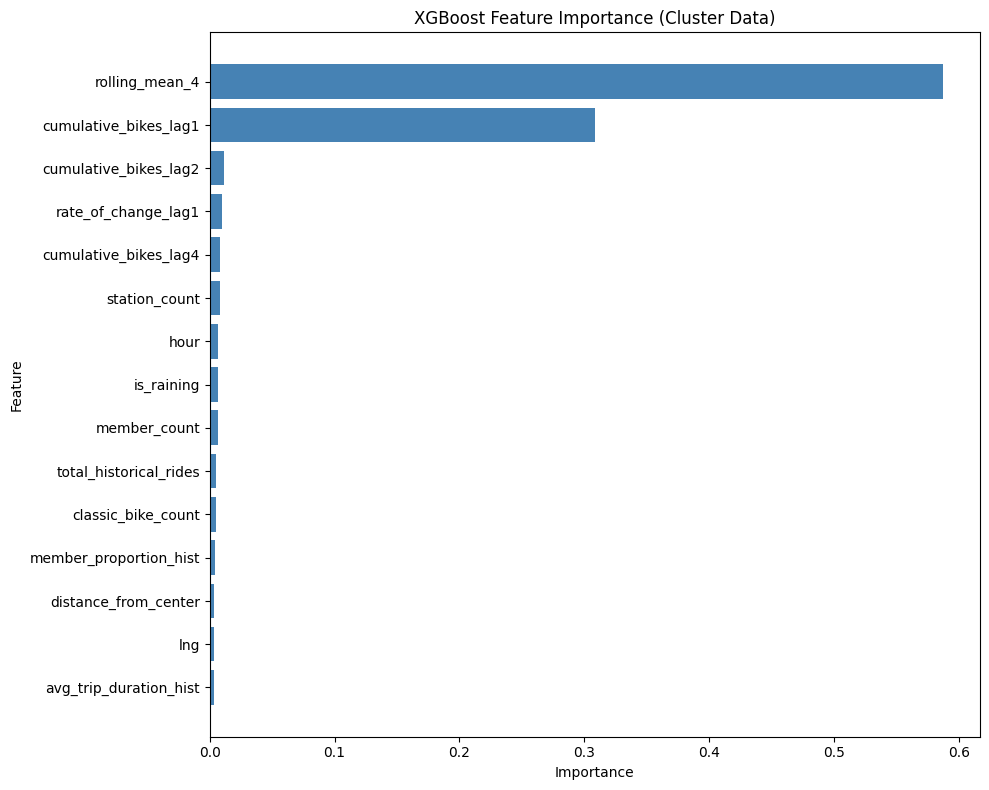

In [12]:
# ============================================================
# FEATURE IMPORTANCE
# ============================================================

# Get feature importances - use X.columns (same as what model was trained on)
importances = xgb_cluster_model.feature_importances_
feature_names = X.columns  # Use X, not X_cluster

print(f"Number of features: {len(feature_names)}")
print(f"Number of importances: {len(importances)}")

# Create DataFrame and sort
importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': importances
}).sort_values('Importance', ascending=False)

print("\nTop 15 Most Important Features:")
print("-"*40)
for idx, row in importance_df.head(15).iterrows():
    print(f"  {row['Feature']:<30} {row['Importance']:.4f}")

# Plot feature importance using matplotlib
plt.figure(figsize=(10, 8))
top_features = importance_df.head(15)
plt.barh(top_features['Feature'], top_features['Importance'], color='steelblue')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('XGBoost Feature Importance (Cluster Data)')
plt.gca().invert_yaxis()  # Highest importance at top
plt.tight_layout()
plt.show()

In [13]:
# Check for data leakage in rolling mean 4 feature
cluster_0 = bike_changes_cluster_aggregated[bike_changes_cluster_aggregated['geo_cluster'] == 0].sort_values('time_interval')
print(cluster_0[['time_interval', 'cumulative_bikes', 'rolling_mean_4']].head(20))


            time_interval  cumulative_bikes  rolling_mean_4
0     2024-08-01 09:00:00                33           21.25
122   2024-08-01 09:15:00                14           20.25
138   2024-08-01 17:00:00                21           21.50
219   2024-08-01 17:15:00                 2           17.50
286   2024-08-01 17:30:00                -4            8.25
362   2024-08-01 17:45:00               -18            0.25
521   2024-08-01 18:00:00                 0           -5.00
532   2024-08-01 18:15:00                -5           -6.75
655   2024-08-01 18:30:00                21           -0.50
704   2024-08-01 18:45:00                10            6.50
820   2024-08-02 08:00:00                -5            5.25
883   2024-08-02 08:15:00               -16            2.50
972   2024-08-02 08:30:00               -29          -10.00
1019  2024-08-02 08:45:00               -14          -16.00
1109  2024-08-02 09:00:00                10          -12.25
1162  2024-08-02 09:15:00               

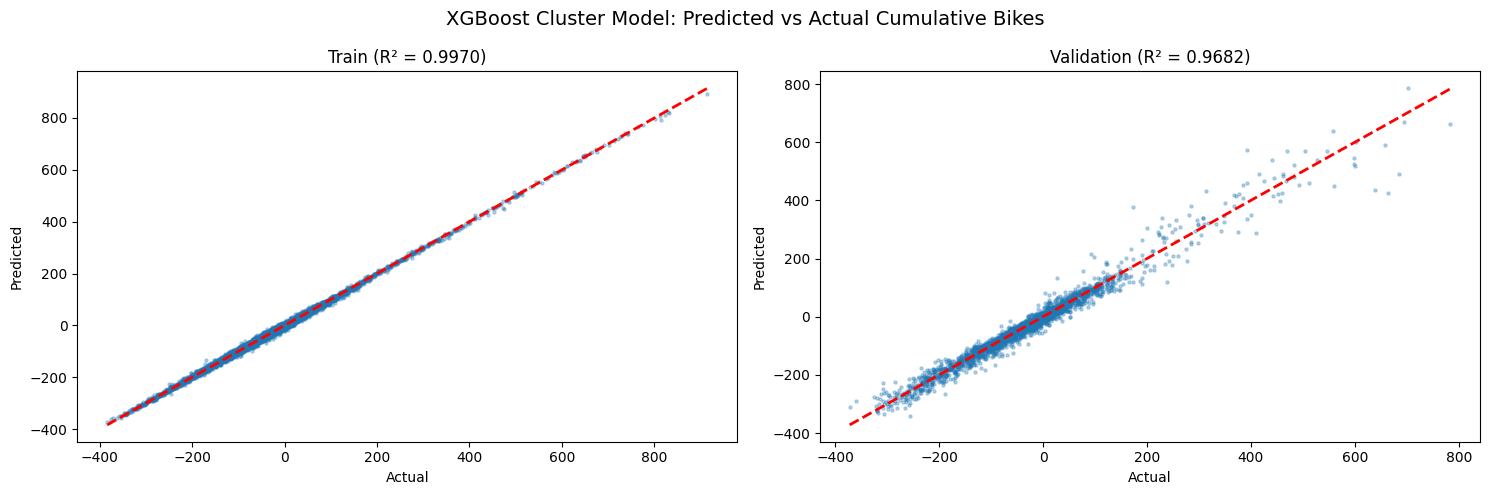

In [14]:
# ============================================================
# PREDICTION VS ACTUAL VISUALIZATION
# ============================================================

# Create scatter plot of predicted vs actual
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Train
axes[0].scatter(y_train_cluster, y_train_pred, alpha=0.3, s=5)
axes[0].plot([y_train_cluster.min(), y_train_cluster.max()],
             [y_train_cluster.min(), y_train_cluster.max()], 'r--', lw=2)
axes[0].set_xlabel('Actual')
axes[0].set_ylabel('Predicted')
axes[0].set_title(f'Train (R² = {train_metrics["R²"]:.4f})')

# Validation
axes[1].scatter(y_val_cluster, y_val_pred, alpha=0.3, s=5)
axes[1].plot([y_val_cluster.min(), y_val_cluster.max()],
             [y_val_cluster.min(), y_val_cluster.max()], 'r--', lw=2)
axes[1].set_xlabel('Actual')
axes[1].set_ylabel('Predicted')
axes[1].set_title(f'Validation (R² = {val_metrics["R²"]:.4f})')

plt.suptitle('XGBoost Cluster Model: Predicted vs Actual Cumulative Bikes', fontsize=14)
plt.tight_layout()
plt.show()

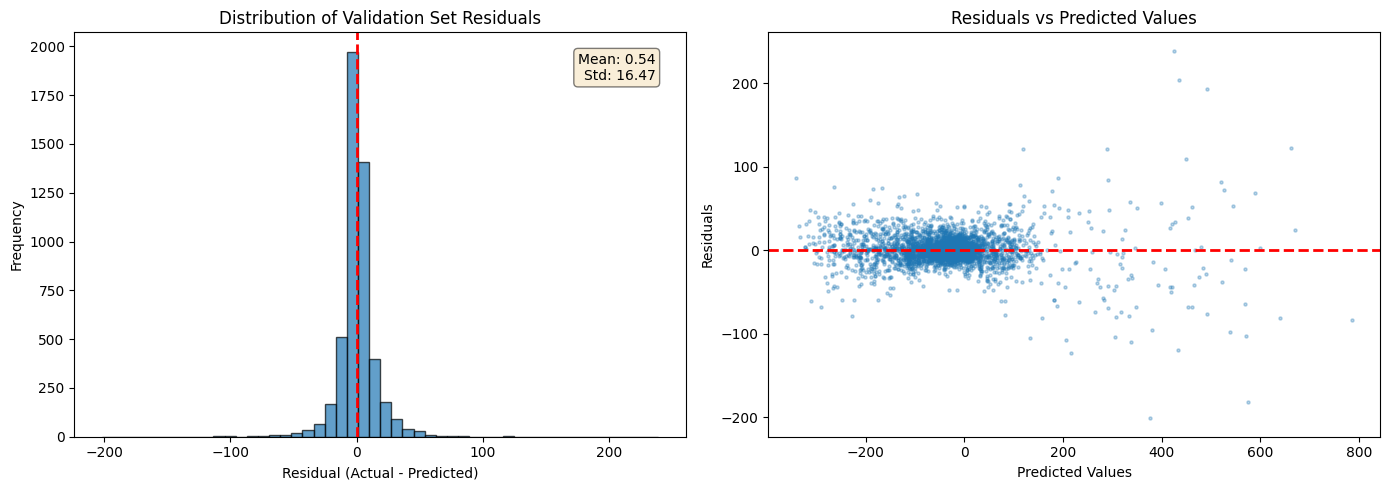


📊 Residual Statistics:
  Mean residual: 0.5382
  Std residual: 16.4711
  Min residual: -201.5232
  Max residual: 238.8332


In [15]:
# ============================================================
# RESIDUAL ANALYSIS
# ============================================================

# Calculate residuals
Validation_residuals = y_val_cluster.values - y_val_pred

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Residual distribution
axes[0].hist(Validation_residuals, bins=50, edgecolor='black', alpha=0.7)
axes[0].axvline(x=0, color='r', linestyle='--', linewidth=2)
axes[0].set_xlabel('Residual (Actual - Predicted)')
axes[0].set_ylabel('Frequency')
axes[0].set_title('Distribution of Validation Set Residuals')
axes[0].text(0.95, 0.95, f'Mean: {np.mean(Validation_residuals):.2f}\nStd: {np.std(Validation_residuals):.2f}',
             transform=axes[0].transAxes, fontsize=10, verticalalignment='top',
             horizontalalignment='right', bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))

# Residuals vs Predicted
axes[1].scatter(y_val_pred, Validation_residuals, alpha=0.3, s=5)
axes[1].axhline(y=0, color='r', linestyle='--', linewidth=2)
axes[1].set_xlabel('Predicted Values')
axes[1].set_ylabel('Residuals')
axes[1].set_title('Residuals vs Predicted Values')

plt.tight_layout()
plt.show()

# Check for bias
print(f"\n📊 Residual Statistics:")
print(f"  Mean residual: {np.mean(Validation_residuals):.4f}")
print(f"  Std residual: {np.std(Validation_residuals):.4f}")
print(f"  Min residual: {np.min(Validation_residuals):.4f}")
print(f"  Max residual: {np.max(Validation_residuals):.4f}")

In [16]:
# ============================================================
# SUMMARY: CLUSTER MODEL PERFORMANCE
# ============================================================

# Original model performance (from hyperparameter search on station-level data)
original_rmse = (-xgb_search.best_score_)**0.5

print("="*60)
print("MODEL COMPARISON SUMMARY")
print("="*60)
print(f"\n📊 Station-Level Model (Original from hyperparameter search):")
print(f"   CV RMSE: {original_rmse:.4f}")

print(f"\n📊 Cluster-Level Model:")
print(f"   Train RMSE: {train_metrics['RMSE']:.4f}")
print(f"   Train MAE:  {train_metrics['MAE']:.4f}")
print(f"   Train R²:   {train_metrics['R²']:.4f}")
print(f"   Val RMSE:   {val_metrics['RMSE']:.4f}")
print(f"   Val MAE:    {val_metrics['MAE']:.4f}")
print(f"   Val R²:     {val_metrics['R²']:.4f}")

print(f"\n💡 Dataset Info:")
print(f"   - Total clusters: {bike_changes_cluster_aggregated['geo_cluster'].nunique()}")
print(f"   - Total rows: {len(bike_changes_cluster_aggregated):,}")
print(f"   - Features used: {X.shape[1]}")

print("\n✅ Model trained on cluster-aggregated data!")

MODEL COMPARISON SUMMARY

📊 Station-Level Model (Original from hyperparameter search):
   CV RMSE: 6.8551

📊 Cluster-Level Model:
   Train RMSE: 4.9047
   Train MAE:  3.6388
   Train R²:   0.9970
   Val RMSE:   16.4799
   Val MAE:    9.2298
   Val R²:     0.9682

💡 Dataset Info:
   - Total clusters: 99
   - Total rows: 24,931
   - Features used: 26

✅ Model trained on cluster-aggregated data!


### Random Forest on Clustered Data

In [ ]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import mean_absolute_error, r2_score

print("="*60)
print("RANDOM FOREST WITH RANDOMIZED SEARCH CV")
print("="*60)

# Define parameter grid
param_distributions = {
    'n_estimators': [100, 200, 300],
    'max_depth': [10, 20, 30, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['sqrt', 0.3, 0.5],
    'bootstrap': [True, False]
}

print(f"\nParameter grid size: {np.prod([len(v) for v in param_distributions.values()]):,} combinations")




RANDOM FOREST WITH RANDOMIZED SEARCH CV

Parameter grid size: 648 combinations


In [ ]:
# Create base model
rf_base = RandomForestRegressor(
    random_state=42,
    n_jobs=-1,
    verbose=0
)

In [ ]:
import time
from datetime import datetime

feature_cols = X_train_cluster.columns.tolist()

print("\n=== ESTIMATING RUNTIME ===")
rf_test = RandomForestRegressor(n_estimators=100, max_depth=20, random_state=42, n_jobs=-1)

start_test = time.time()
rf_test.fit(X_train_cluster, y_train_cluster)
test_duration = time.time() - start_test

print(f"Single RF (100 trees) fit time: {test_duration:.1f} seconds")

# Estimate total time
avg_trees = 200  # Average of param range
scaling_factor = avg_trees / 100
estimated_single = test_duration * scaling_factor
estimated_total = 150 * estimated_single  # 25 iter × 3 CV folds

print(f"\nEstimated total time:")
print(f"  Per model (~300 trees): {estimated_single:.1f} seconds")
print(f"  Total (50 × 3 CV): {estimated_total/60:.1f} minutes ({estimated_total/3600:.1f} hours)")

# RandomizedSearchCV
random_search = RandomizedSearchCV(
    estimator=rf_base,
    param_distributions=param_distributions,
    n_iter=25,
    cv=3,
    scoring='neg_mean_absolute_error',
    n_jobs=-1,
    verbose=3,
    random_state=42,
    return_train_score=True
)

print(f"\n=== RANDOMIZEDSEARCHCV SETTINGS ===")
print(f"  Training samples: {len(X_train_cluster):,}")
print(f"  Features: {len(feature_cols)}")
print(f"  CV folds: 3")
print(f"  Random iterations: 50")
print(f"  Total fits: 150 (50 × 3)")
print(f"  Scoring: MAE")

# Start training
print(f"\n{'='*60}")
print(f"STARTING RANDOMIZEDSEARCHCV")
print(f"Start time: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}")
print(f"{'='*60}\n")

start_time = time.time()

print(f"\nSettings:")
print(f"  Training samples: {len(X_train_cluster):,}")
print(f"  Features: {len(feature_cols)}")
print(f"  CV folds: 3")
print(f"  Random iterations: 25")
print(f"  Scoring: MAE")

# Train
print(f"\nStarting RandomizedSearchCV...")
print("This will take several minutes...\n")

random_search.fit(X_train_cluster, y_train_cluster)

# Calculate duration
end_time = time.time()
total_duration = end_time - start_time

print(f"\n{'='*60}")
print(f"RANDOMIZEDSEARCHCV COMPLETE!")
print(f"{'='*60}")
print(f"End time: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}")
print(f"Total duration: {total_duration/60:.1f} minutes ({total_duration/3600:.2f} hours)")
print(f"Average per fit: {total_duration/150:.1f} seconds")

# Best results
print(f"\n=== BEST RESULTS ===")
print(f"Best CV MAE: {-random_search.best_score_:.2f} bikes")
print(f"\nBest parameters:")
for param, value in random_search.best_params_.items():
    print(f"  {param}: {value}")

# Save best model
best_rf = random_search.best_estimator_


=== ESTIMATING RUNTIME ===
Single RF (100 trees) fit time: 31.7 seconds

Estimated total time:
  Per model (~300 trees): 63.4 seconds
  Total (50 × 3 CV): 158.6 minutes (2.6 hours)

=== RANDOMIZEDSEARCHCV SETTINGS ===
  Training samples: 14,958
  Features: 26
  CV folds: 3
  Random iterations: 50
  Total fits: 150 (50 × 3)
  Scoring: MAE

STARTING RANDOMIZEDSEARCHCV
Start time: 2025-12-07 01:22:18


Settings:
  Training samples: 14,958
  Features: 26
  CV folds: 3
  Random iterations: 25
  Scoring: MAE

Starting RandomizedSearchCV...
This will take several minutes...

Fitting 3 folds for each of 25 candidates, totalling 75 fits

RANDOMIZEDSEARCHCV COMPLETE!
End time: 2025-12-07 01:39:58
Total duration: 17.7 minutes (0.29 hours)
Average per fit: 7.1 seconds

=== BEST RESULTS ===
Best CV MAE: 10.15 bikes

Best parameters:
  n_estimators: 300
  min_samples_split: 5
  min_samples_leaf: 2
  max_features: 0.5
  max_depth: None
  bootstrap: False


### --> Load saved best RF parameters here

In [18]:
import json

file_path = '/content/drive/MyDrive/Colab Notebooks/best_rf_hyperparams.json'

with open(file_path, 'r') as f:
    best_params = json.load(f)

print("Loaded parameters:", best_params)


Loaded parameters: {'n_estimators': 300, 'min_samples_split': 5, 'min_samples_leaf': 2, 'max_features': 0.5, 'max_depth': None, 'bootstrap': False}


In [21]:
# Re-train model
from sklearn.ensemble import RandomForestRegressor

best_rf = RandomForestRegressor(**best_params, random_state=42)

best_rf.fit(X_train_cluster,y_train_cluster)

RandomForestRegressor(bootstrap=False, max_features=0.5, min_samples_leaf=2,
                      min_samples_split=5, n_estimators=300, random_state=42)

In [22]:
print("="*60)
print("RANDOM FOREST EVALUATION - TRAIN & VAL")
print("="*60)

# Get best model
#best_rf = random_search.best_estimator_

#print(f"\n=== BEST PARAMETERS ===")
#for param, value in random_search.best_params_.items():
#    print(f"  {param}: {value}")

#print(f"\nBest CV MAE: {-random_search.best_score_:.2f} bikes")

# Make predictions
print(f"\n=== MAKING PREDICTIONS ===")
y_pred_train = best_rf.predict(X_train_cluster)
y_pred_val = best_rf.predict(X_val_cluster)
print("✓ Predictions generated")

# Training Set Evaluation
print(f"\n{'='*60}")
print("TRAINING SET (ALL HOURS)")
print(f"{'='*60}")

train_mae = mean_absolute_error(y_train_cluster, y_pred_train)
train_rmse = np.sqrt(mean_squared_error(y_train_cluster, y_pred_train))
train_r2 = r2_score(y_train_cluster, y_pred_train)

print(f"Samples: {len(y_train_cluster):,}")
print(f"MAE:  {train_mae:.2f} bikes")
print(f"RMSE: {train_rmse:.2f} bikes")
print(f"R²:   {train_r2:.4f}")

# Validation Set Evaluation
print(f"\n{'='*60}")
print("VALIDATION SET (ALL HOURS)")
print(f"{'='*60}")

val_mae = mean_absolute_error(y_val_cluster, y_pred_val)
val_rmse = np.sqrt(mean_squared_error(y_val_cluster, y_pred_val))
val_r2 = r2_score(y_val_cluster, y_pred_val)

print(f"Samples: {len(y_val_cluster):,}")
print(f"MAE:  {val_mae:.2f} bikes")
print(f"RMSE: {val_rmse:.2f} bikes")
print(f"R²:   {val_r2:.4f}")

# Check for overfitting
print(f"\n{'='*60}")
print("OVERFITTING CHECK")
print(f"{'='*60}")

mae_diff = train_mae - val_mae
r2_diff = train_r2 - val_r2

print(f"Train MAE: {train_mae:.2f}")
print(f"Val MAE:   {val_mae:.2f}")
print(f"Difference: {mae_diff:.2f} ({'overfitting' if mae_diff < -0.5 else 'okay'})")

print(f"\nTrain R²: {train_r2:.4f}")
print(f"Val R²:   {val_r2:.4f}")
print(f"Difference: {r2_diff:.4f} ({'overfitting' if r2_diff > 0.1 else 'okay'})")

if train_r2 - val_r2 > 0.1:
    print("\n⚠️ Model may be overfitting (train R² much higher than val R²)")
elif abs(train_r2 - val_r2) < 0.05:
    print("\n✓ Good generalization (train and val R² are close)")

RANDOM FOREST EVALUATION - TRAIN & VAL

=== MAKING PREDICTIONS ===
✓ Predictions generated

TRAINING SET (ALL HOURS)
Samples: 14,958
MAE:  1.19 bikes
RMSE: 3.07 bikes
R²:   0.9988

VALIDATION SET (ALL HOURS)
Samples: 4,986
MAE:  9.45 bikes
RMSE: 16.47 bikes
R²:   0.9683

OVERFITTING CHECK
Train MAE: 1.19
Val MAE:   9.45
Difference: -8.27 (overfitting)

Train R²: 0.9988
Val R²:   0.9683
Difference: 0.0306 (okay)

✓ Good generalization (train and val R² are close)


## Model Comparison

In [23]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np

print("="*60)
print("CALCULATING ALL METRICS")
print("="*60)

# ============================================
# XGBOOST METRICS
# ============================================
print("\n=== XGBoost ===")

# XGBoost - Training predictions
y_pred_train_xgb = xgb_cluster_model.predict(X_train_cluster)
xgb_train_mae = mean_absolute_error(y_train_cluster, y_pred_train_xgb)
xgb_train_rmse = np.sqrt(mean_squared_error(y_train_cluster, y_pred_train_xgb))
xgb_train_r2 = r2_score(y_train_cluster, y_pred_train_xgb)

print(f"Train - MAE: {xgb_train_mae:.2f}, RMSE: {xgb_train_rmse:.2f}, R²: {xgb_train_r2:.4f}")

# XGBoost - Validation predictions
y_pred_val_xgb = xgb_cluster_model.predict(X_val_cluster)
xgb_val_mae = mean_absolute_error(y_val_cluster, y_pred_val_xgb)
xgb_val_rmse = np.sqrt(mean_squared_error(y_val_cluster, y_pred_val_xgb))
xgb_val_r2 = r2_score(y_val_cluster, y_pred_val_xgb)

print(f"Val   - MAE: {xgb_val_mae:.2f}, RMSE: {xgb_val_rmse:.2f}, R²: {xgb_val_r2:.4f}")

# ============================================
# RANDOM FOREST METRICS
# ============================================
print("\n=== Random Forest ===")

# RF - Training predictions
y_pred_train_rf = best_rf.predict(X_train_cluster)
rf_train_mae = mean_absolute_error(y_train_cluster, y_pred_train_rf)
rf_train_rmse = np.sqrt(mean_squared_error(y_train_cluster, y_pred_train_rf))
rf_train_r2 = r2_score(y_train_cluster, y_pred_train_rf)

print(f"Train - MAE: {rf_train_mae:.2f}, RMSE: {rf_train_rmse:.2f}, R²: {rf_train_r2:.4f}")

# RF - Validation predictions
y_pred_val_rf = best_rf.predict(X_val_cluster)
rf_val_mae = mean_absolute_error(y_val_cluster, y_pred_val_rf)
rf_val_rmse = np.sqrt(mean_squared_error(y_val_cluster, y_pred_val_rf))
rf_val_r2 = r2_score(y_val_cluster, y_pred_val_rf)

print(f"Val   - MAE: {rf_val_mae:.2f}, RMSE: {rf_val_rmse:.2f}, R²: {rf_val_r2:.4f}")

print("\n✓ All metrics calculated!")

CALCULATING ALL METRICS

=== XGBoost ===
Train - MAE: 3.64, RMSE: 4.90, R²: 0.9970
Val   - MAE: 9.23, RMSE: 16.48, R²: 0.9682

=== Random Forest ===
Train - MAE: 1.19, RMSE: 3.07, R²: 0.9988
Val   - MAE: 9.45, RMSE: 16.47, R²: 0.9683

✓ All metrics calculated!


In [24]:
print("="*60)
print("MODEL COMPARISON: XGBOOST vs RANDOM FOREST")
print("="*60)


# Create comparison table
comparison = pd.DataFrame({
    'Metric': ['MAE (bikes)', 'RMSE (bikes)', 'R²'],

    'XGBoost Train': [
        f'{xgb_train_mae:.2f}',
        f'{xgb_train_rmse:.2f}',
        f'{xgb_train_r2:.4f}'
    ],
    'XGBoost Val': [
        f'{xgb_val_mae:.2f}',
        f'{xgb_val_rmse:.2f}',
        f'{xgb_val_r2:.4f}'
    ],

    'RF Train': [
        f'{train_mae:.2f}',
        f'{train_rmse:.2f}',
        f'{train_r2:.4f}'
    ],
    'RF Val': [
        f'{val_mae:.2f}',
        f'{val_rmse:.2f}',
        f'{val_r2:.4f}'
    ]
})

print("\n" + comparison.to_string(index=False))

# Determine winner
print(f"\n{'='*60}")
print("WINNER BY METRIC (Validation Set)")
print(f"{'='*60}")

if xgb_val_mae < val_mae:
    mae_winner = f"XGBoost ({xgb_val_mae:.2f} < {val_mae:.2f})"
else:
    mae_winner = f"Random Forest ({val_mae:.2f} < {xgb_val_mae:.2f})"

if xgb_val_rmse < val_rmse:
    rmse_winner = f"XGBoost ({xgb_val_rmse:.2f} < {val_rmse:.2f})"
else:
    rmse_winner = f"Random Forest ({val_rmse:.2f} < {xgb_val_rmse:.2f})"

if xgb_val_r2 > val_r2:
    r2_winner = f"XGBoost ({xgb_val_r2:.4f} > {val_r2:.4f})"
else:
    r2_winner = f"Random Forest ({val_r2:.4f} > {xgb_val_r2:.4f})"

print(f"MAE:  {mae_winner}")
print(f"RMSE: {rmse_winner}")
print(f"R²:   {r2_winner}")

MODEL COMPARISON: XGBOOST vs RANDOM FOREST

      Metric XGBoost Train XGBoost Val RF Train RF Val
 MAE (bikes)          3.64        9.23     1.19   9.45
RMSE (bikes)          4.90       16.48     3.07  16.47
          R²        0.9970      0.9682   0.9988 0.9683

WINNER BY METRIC (Validation Set)
MAE:  XGBoost (9.23 < 9.45)
RMSE: Random Forest (16.47 < 16.48)
R²:   Random Forest (0.9683 > 0.9682)


In [ ]:
#import joblib

#joblib.dump(random_search.best_estimator_, "/content/drive/MyDrive/Colab Notebooks/rf_model.json")

['/content/drive/MyDrive/Colab Notebooks/rf_model.json']

In [ ]:
#import json

#with open("/content/drive/MyDrive/Colab Notebooks/best_rf_hyperparams.json", "w") as f:
    json.dump(random_search.best_params_, f, indent=4)

In [25]:
print(f"\n{'='*60}")
print("OVERFITTING CHECK")
print(f"{'='*60}")

overfitting_comp = pd.DataFrame({
    'Model': ['XGBoost', 'Random Forest'],
    'Train R²': [xgb_train_r2, train_r2],
    'Val R²': [xgb_val_r2, val_r2],
    'Difference': [
        xgb_train_r2 - xgb_val_r2,
        train_r2 - val_r2
    ],
    'Status': [
        'Overfitting' if (xgb_train_r2 - xgb_val_r2) > 0.1 else 'Good',
        'Overfitting' if (train_r2 - val_r2) > 0.1 else 'Good'
    ]
})

print("\n" + overfitting_comp.to_string(index=False))
print("\nNote: Difference > 0.1 suggests overfitting")


OVERFITTING CHECK

        Model  Train R²   Val R²  Difference Status
      XGBoost  0.997039 0.968213    0.028826   Good
Random Forest  0.998838 0.968266    0.030572   Good

Note: Difference > 0.1 suggests overfitting


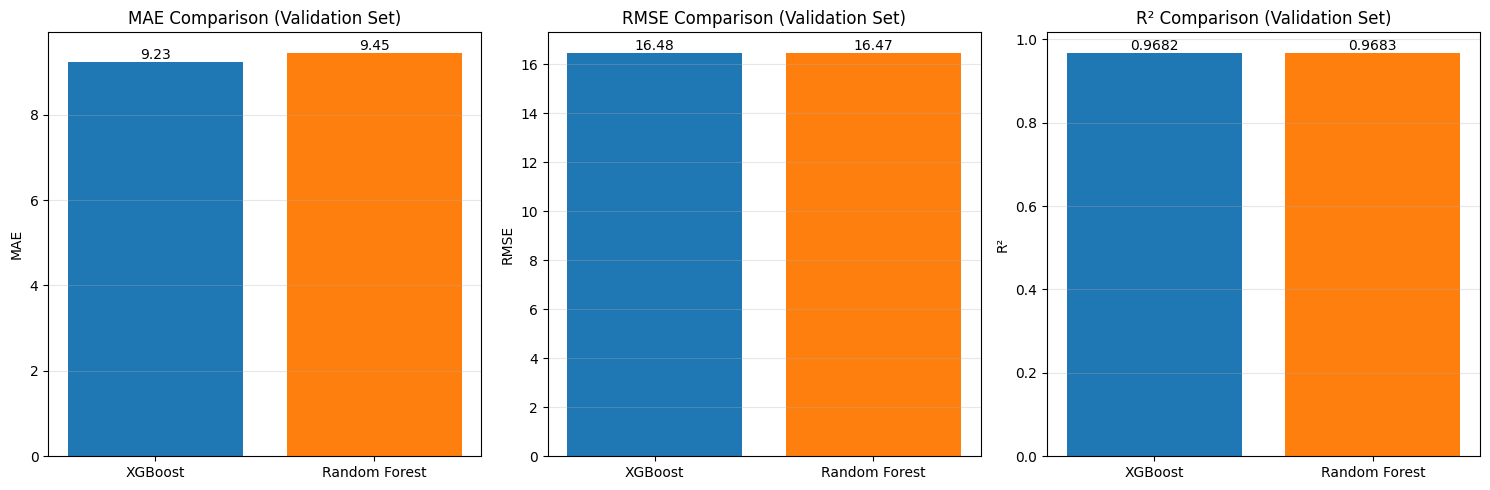

In [26]:
# Bar chart comparison
metrics = ['MAE', 'RMSE', 'R²']
xgb_scores = [xgb_val_mae, xgb_val_rmse, xgb_val_r2]
rf_scores = [val_mae, val_rmse, val_r2]

fig, axes = plt.subplots(1, 3, figsize=(15, 5))

for i, (metric, ax) in enumerate(zip(metrics, axes)):
    models = ['XGBoost', 'Random Forest']
    values = [xgb_scores[i], rf_scores[i]]

    bars = ax.bar(models, values, color=['#1f77b4', '#ff7f0e'])
    ax.set_ylabel(metric)
    ax.set_title(f'{metric} Comparison (Validation Set)')
    ax.grid(axis='y', alpha=0.3)

    # Add value labels on bars
    for bar, val in zip(bars, values):
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2., height,
                f'{val:.2f}' if i < 2 else f'{val:.4f}',
                ha='center', va='bottom')

plt.tight_layout()
plt.show()

## Error Analysis on Random Forest

### RF Cross Validation Score

In [30]:
import time
from sklearn.model_selection import cross_val_score

start = time.time()

# Get cross-validation scores
cv_scores = cross_val_score(
    best_rf, X_train_cluster, y_train_cluster,
    cv=3,
    scoring='neg_mean_squared_error'
)

elapsed = time.time() - start

print(f"CV MSE: {-cv_scores.mean():.4f} (+/- {cv_scores.std():.4f})")
print(f"Time taken: {elapsed:.1f} seconds")

CV MSE: 337.6847 (+/- 26.6246)
Time taken: 227.1 seconds


### Validation Curve

In [31]:
from sklearn.model_selection import validation_curve

param_distributions = {
    'n_estimators': [100, 200, 300],
    'max_depth': [10, 20, 30, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['sqrt', 0.3, 0.5],
    'bootstrap': [True, False]
}

# Storage for results
validation_results = {}

print("Starting validation curve analysis...")
start_time = time.time()

for param_name, param_range in param_distributions.items():
    print(f"\nTesting {param_name}...")
    param_start = time.time()

    train_scores, val_scores = validation_curve(
        RandomForestRegressor(random_state=42),
        X_train_cluster, y_train_cluster,
        param_name=param_name,
        param_range=param_range,
        cv=3,  # Same as your original
        scoring="neg_mean_squared_error",  # or "r2", "neg_mean_absolute_error"
        n_jobs=-1,  # Use all cores
        verbose=0
    )

    # Convert to positive
    train_scores = -train_scores
    val_scores = -val_scores

    # Store results
    validation_results[param_name] = {
        'param_range': param_range,
        'train_scores': train_scores,
        'val_scores': val_scores,
        'train_mean': np.mean(train_scores, axis=1),
        'train_std': np.std(train_scores, axis=1),
        'val_mean': np.mean(val_scores, axis=1),
        'val_std': np.std(val_scores, axis=1)
    }

    param_time = time.time() - param_start
    print(f"  Completed in {param_time:.1f} seconds")

total_time = time.time() - start_time
print(f"\n{'='*50}")
print(f"Total time: {total_time/60:.2f} minutes")
print(f"{'='*50}")



Starting validation curve analysis...

Testing n_estimators...
  Completed in 544.7 seconds

Testing max_depth...
  Completed in 303.3 seconds

Testing min_samples_split...
  Completed in 243.9 seconds

Testing min_samples_leaf...
  Completed in 230.4 seconds

Testing max_features...
  Completed in 92.6 seconds

Testing bootstrap...
  Completed in 227.5 seconds

Total time: 27.37 minutes


In [32]:
# Save the validation results
import pickle

with open('/content/drive/MyDrive/Colab Notebooks/validation_curve_results.pkl', 'wb') as f:
    pickle.dump(validation_results, f)

print("Validation curve results saved!")

Validation curve results saved!


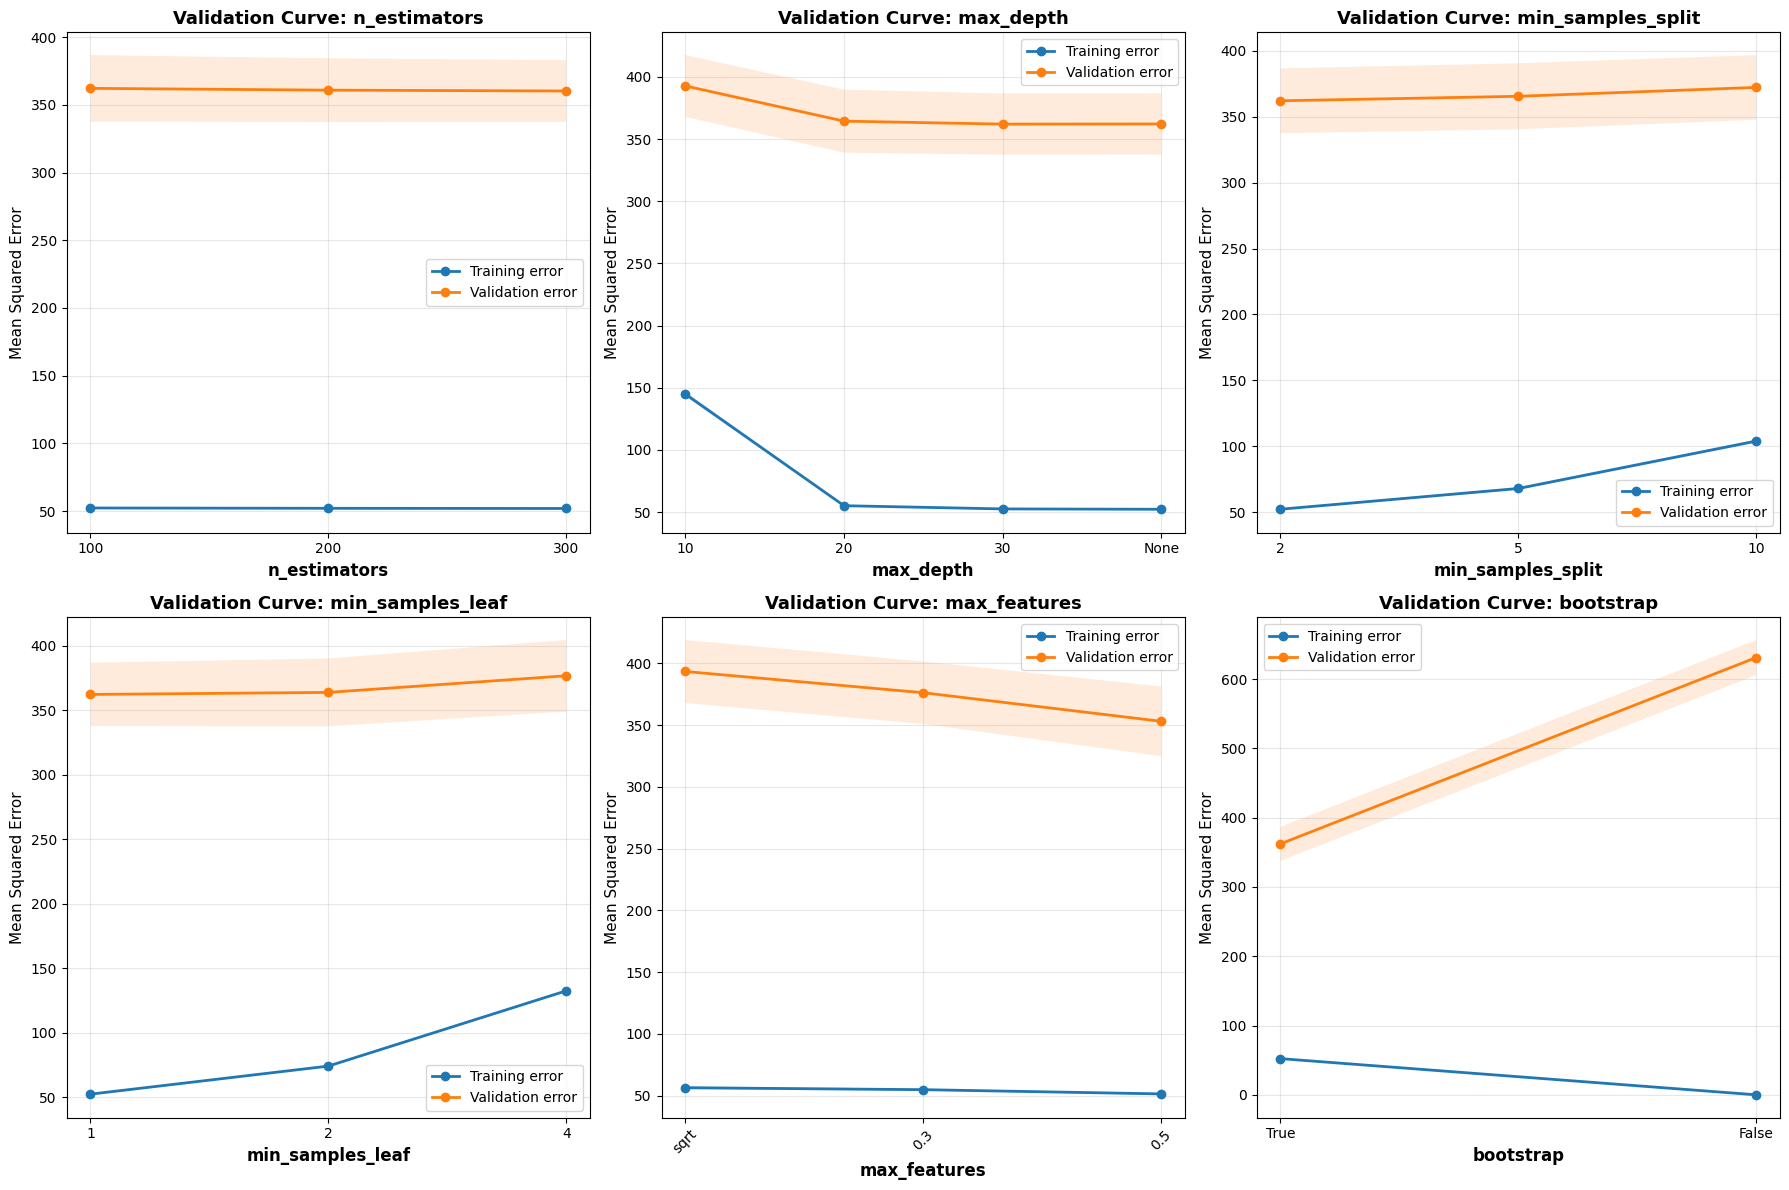


SUMMARY: Best parameter values based on validation error
n_estimators        : 300             (Val MSE: 360.2059)
max_depth           : 30              (Val MSE: 362.0289)
min_samples_split   : 2               (Val MSE: 362.1587)
min_samples_leaf    : 1               (Val MSE: 362.1587)
max_features        : 0.5             (Val MSE: 353.1867)
bootstrap           : True            (Val MSE: 362.1587)


In [34]:
# Plot all validation curves
fig, axes = plt.subplots(2, 3, figsize=(18, 12))
axes = axes.flatten()

for idx, (param_name, results) in enumerate(validation_results.items()):
    ax = axes[idx]

    param_range = results['param_range']
    train_mean = results['train_mean']
    train_std = results['train_std']
    val_mean = results['val_mean']
    val_std = results['val_std']

    # Helper function to check if all values are numeric
    def is_all_numeric(values):
        return all(isinstance(v, (int, float)) or v is None for v in values)

    # Use indices for non-numeric or mixed-type parameters
    if not is_all_numeric(param_range):
        x_values = np.arange(len(param_range))
        ax.set_xticks(x_values)
        ax.set_xticklabels([str(v) for v in param_range], rotation=45)
    else:
        # For numeric parameters, handle None specially
        x_values = np.arange(len(param_range))
        ax.set_xticks(x_values)
        ax.set_xticklabels([str(v) if v is not None else 'None' for v in param_range])

    # Plot training and validation curves
    ax.plot(x_values, train_mean, label='Training error', marker='o', linewidth=2)
    ax.plot(x_values, val_mean, label='Validation error', marker='o', linewidth=2)

    # Add shaded regions for std deviation
    ax.fill_between(x_values,
                    train_mean - train_std,
                    train_mean + train_std,
                    alpha=0.15)
    ax.fill_between(x_values,
                    val_mean - val_std,
                    val_mean + val_std,
                    alpha=0.15)

    ax.set_xlabel(param_name, fontsize=12, fontweight='bold')
    ax.set_ylabel('Mean Squared Error', fontsize=11)
    ax.set_title(f'Validation Curve: {param_name}', fontsize=13, fontweight='bold')
    ax.legend(loc='best')
    ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('validation_curves_all_params.png', dpi=300, bbox_inches='tight')
plt.show()

# Print summary
print("\n" + "="*50)
print("SUMMARY: Best parameter values based on validation error")
print("="*50)
for param_name, results in validation_results.items():
    best_idx = np.argmin(results['val_mean'])
    best_value = results['param_range'][best_idx]
    best_error = results['val_mean'][best_idx]
    print(f"{param_name:20s}: {str(best_value):15s} (Val MSE: {best_error:.4f})")

From the above validation curves, we see that:

*   n_estimators is tuned correctly given the flat performance. We can try reducing # of trees down to 100 to reduce compute.
*   The max_depth shows slight overfitting with a large decline in training error and only a small uptick in validation error. We will try adjusting this to 25 to reduce overfitting.
*   The max_samples_split hyperparameter will be kept at 2.
*   The min_samples_leaf will be kept at 1
*   the max_features hyperparameter showed that by increasing it we can reduce error on validation set. We will adjust this up to 0.7
*   Bootstrap clearly shows that only True will not cause drastic overfitting of the model






## New Parameters for RF based on error analysis

In [38]:
improved_params = {
    'n_estimators': 150,
    'max_depth': 25,
    'min_samples_split': 2,
    'min_samples_leaf': 1,
    'max_features': 0.7,
    'bootstrap': True,
    'random_state': 42
}

# Train improved model
print("\n" + "="*60)
print("Training IMPROVED model...")
print("="*60)
rf_improved = RandomForestRegressor(**improved_params)
rf_improved.fit(X_train_cluster, y_train_cluster)

y_train_pred_imp = rf_improved.predict(X_train_cluster)
y_val_pred_imp = rf_improved.predict(X_val_cluster)

train_mae_imp = mean_absolute_error(y_train_cluster, y_train_pred_imp)
train_rmse_imp = np.sqrt(mean_squared_error(y_train_cluster, y_train_pred_imp))
train_r2_imp = r2_score(y_train_cluster, y_train_pred_imp)

val_mae_imp = mean_absolute_error(y_val_cluster, y_val_pred_imp)
val_rmse_imp = np.sqrt(mean_squared_error(y_val_cluster, y_val_pred_imp))
val_r2_imp = r2_score(y_val_cluster, y_val_pred_imp)


Training IMPROVED model...


In [39]:
# Compare results
print("\n" + "="*60)
print("COMPARISON: TRAINING SET")
print("="*60)
print(f"{'Metric':<15} {'Original':<15} {'Improved':<15} {'Change':<15}")
print("-"*60)
print(f"{'MAE':<15} {train_mae:<15.2f} {train_mae_imp:<15.2f} {train_mae_imp-train_mae:<+15.2f}")
print(f"{'RMSE':<15} {train_rmse:<15.2f} {train_rmse_imp:<15.2f} {train_rmse_imp-train_rmse:<+15.2f}")
print(f"{'R²':<15} {train_r2:<15.4f} {train_r2_imp:<15.4f} {train_r2_imp-train_r2:<+15.4f}")

print("\n" + "="*60)
print("COMPARISON: VALIDATION SET")
print("="*60)
print(f"{'Metric':<15} {'Original':<15} {'Improved':<15} {'Change':<15}")
print("-"*60)
print(f"{'MAE':<15} {val_mae:<15.2f} {val_mae_imp:<15.2f} {val_mae_imp-val_mae:<+15.2f}")
print(f"{'RMSE':<15} {val_rmse:<15.2f} {val_rmse_imp:<15.2f} {val_rmse_imp-val_rmse:<+15.2f}")
print(f"{'R²':<15} {val_r2:<15.4f} {val_r2_imp:<15.4f} {val_r2_imp-val_r2:<+15.4f}")


COMPARISON: TRAINING SET
Metric          Original        Improved        Change         
------------------------------------------------------------
MAE             1.19            3.81            +2.62          
RMSE            3.07            6.83            +3.76          
R²              0.9988          0.9943          -0.0046        

COMPARISON: VALIDATION SET
Metric          Original        Improved        Change         
------------------------------------------------------------
MAE             9.45            9.71            +0.26          
RMSE            16.47           16.99           +0.53          
R²              0.9683          0.9662          -0.0021        


We will now look into fine tuning the max_features parameter by itself.

In [49]:
# Test only max_features
fine_tuned_params = {
    'n_estimators': 150,
    'max_depth': 25,
    'min_samples_split': 2,
    'min_samples_leaf': 1,
    'bootstrap': True,
}

print("Testing max_features optimization...")
print("="*60)

results = []
for max_feat in [0.45, 0.5, 0.55, 0.6, 0.65, 0.7, 0.8]:
    params = {**fine_tuned_params, 'max_features': max_feat}
    rf = RandomForestRegressor(**params, random_state=42)
    rf.fit(X_train_cluster, y_train_cluster)

    val_pred_3 = rf.predict(X_val_cluster)
    val_rmse_3 = np.sqrt(mean_squared_error(y_val_cluster, val_pred_3))
    val_mae_3 = mean_absolute_error(y_val_cluster, val_pred_3)
    val_r2_3 = r2_score(y_val_cluster, val_pred_3)

    results.append({
        'max_features': max_feat,
        'val_rmse': val_rmse_3,
        'val_r2': val_r2_3,
        'val_mae': val_mae_3
    })

    print(f"max_features={max_feat:.2f}: MAE={val_mae_3:.3f}, RMSE={val_rmse_3:.3f}, R²={val_r2_3:.4f}")

# Find best
best = min(results, key=lambda x: x['val_rmse'])
print(f"\n✓ Best: max_features={best['max_features']}, RMSE={best['val_rmse']:.3f}")
print(f"MAE:  {best['val_mae']:.3f} bikes")
print(f"R²:   {best['val_r2']:.4f}")

improvement = val_rmse - best['val_rmse']
if improvement > 0.1:  # Only if meaningful improvement
    print(f"  Improvement: {improvement:.2f} bikes")
else:
    print(f"  No meaningful improvement - stick with original parameters")

Testing max_features optimization...
max_features=0.45: MAE=9.725, RMSE=16.858, R²=0.9667
max_features=0.50: MAE=9.691, RMSE=16.740, R²=0.9672
max_features=0.55: MAE=9.673, RMSE=16.769, R²=0.9671
max_features=0.60: MAE=9.689, RMSE=16.964, R²=0.9663
max_features=0.65: MAE=9.657, RMSE=16.904, R²=0.9666
max_features=0.70: MAE=9.712, RMSE=16.995, R²=0.9662
max_features=0.80: MAE=9.684, RMSE=17.037, R²=0.9660

✓ Best: max_features=0.5, RMSE=16.740
MAE:  9.691 bikes
R²:   0.9672
  Improvement: 0.22 bikes


In [53]:
# Compare to original
print("\n" + "="*60)
print("COMPARISON TO ORIGINAL")
print("="*60)
print(f"Original MAE:  {val_mae:.2f} bikes")
print(f"Original RMSE: {val_rmse:.2f} bikes")
print(f"Original R²:   {val_r2:.4f}")

print()
mae_change = best['val_mae'] - val_mae
rmse_change = best['val_rmse'] - val_rmse
r2_change = best['val_r2'] - val_r2

print(f"MAE change:  {mae_change:+.2f} bikes")
print(f"RMSE change: {rmse_change:+.2f} bikes")
print(f"R² change:   {r2_change:+.4f}")

if rmse_change < -0.1:  # Improvement threshold
    print(f"\n✓ Meaningful improvement! Consider updating max_features to {best['max_features']}")
else:
    print(f"\n○ No meaningful improvement - original parameters are already optimal")


COMPARISON TO ORIGINAL
Original MAE:  9.69 bikes
Original RMSE: 16.96 bikes
Original R²:   0.9663

MAE change:  +0.00 bikes
RMSE change: -0.22 bikes
R² change:   +0.0009

✓ Meaningful improvement! Consider updating max_features to 0.5


In [54]:
# Further Error Analysis
print("="*70)
print("TRAINING FINAL MODEL WITH BEST PARAMETERS")
print("="*70)

best_params_final = {
    **fine_tuned_params,
    'max_features': best['max_features']
}
print(f"Best parameters: {best_params_final}")

rf_final = RandomForestRegressor(**best_params_final, random_state=42)
rf_final.fit(X_train_cluster, y_train_cluster)
print("✓ Model trained successfully\n")

TRAINING FINAL MODEL WITH BEST PARAMETERS
Best parameters: {'n_estimators': 150, 'max_depth': 25, 'min_samples_split': 2, 'min_samples_leaf': 1, 'bootstrap': True, 'max_features': 0.5}
✓ Model trained successfully



In [55]:
# Now run the error analysis function
def error_analysis(trained_model, X_train, y_train, X_val, y_val, dataset_name="Validation"):

    # Get predictions using the trained_model
    y_train_pred = trained_model.predict(X_train)
    y_val_pred = trained_model.predict(X_val)

    # Calculate metrics
    train_mae = mean_absolute_error(y_train, y_train_pred)
    train_rmse = np.sqrt(mean_squared_error(y_train, y_train_pred))
    train_r2 = r2_score(y_train, y_train_pred)

    val_mae = mean_absolute_error(y_val, y_val_pred)
    val_rmse = np.sqrt(mean_squared_error(y_val, y_val_pred))
    val_r2 = r2_score(y_val, y_val_pred)

    # Calculate residuals
    train_residuals = y_train - y_train_pred
    val_residuals = y_val - y_val_pred

    # Create figure with 4 subplots
    fig, axes = plt.subplots(2, 2, figsize=(16, 12))

    # 1. Predicted vs Actual - Training Set
    ax1 = axes[0, 0]
    ax1.scatter(y_train, y_train_pred, alpha=0.4, s=20, label='Training data')

    # Perfect prediction line
    min_val = min(y_train.min(), y_train_pred.min())
    max_val = max(y_train.max(), y_train_pred.max())
    ax1.plot([min_val, max_val], [min_val, max_val], 'r--', lw=2, label='Perfect prediction')

    ax1.set_xlabel('Actual Bike Count', fontsize=12, fontweight='bold')
    ax1.set_ylabel('Predicted Bike Count', fontsize=12, fontweight='bold')
    ax1.set_title(f'Training Set: Predicted vs Actual\nR² = {train_r2:.4f}, RMSE = {train_rmse:.2f}',
                  fontsize=13, fontweight='bold')
    ax1.legend()
    ax1.grid(True, alpha=0.3)

    # 2. Predicted vs Actual - Validation Set
    ax2 = axes[0, 1]
    ax2.scatter(y_val, y_val_pred, alpha=0.4, s=20, color='orange', label=f'{dataset_name} data')

    min_val = min(y_val.min(), y_val_pred.min())
    max_val = max(y_val.max(), y_val_pred.max())
    ax2.plot([min_val, max_val], [min_val, max_val], 'r--', lw=2, label='Perfect prediction')

    ax2.set_xlabel('Actual Bike Count', fontsize=12, fontweight='bold')
    ax2.set_ylabel('Predicted Bike Count', fontsize=12, fontweight='bold')
    ax2.set_title(f'{dataset_name} Set: Predicted vs Actual\nR² = {val_r2:.4f}, RMSE = {val_rmse:.2f}',
                  fontsize=13, fontweight='bold')
    ax2.legend()
    ax2.grid(True, alpha=0.3)

    # 3. Residual Plot - Validation Set
    ax3 = axes[1, 0]
    ax3.scatter(y_val_pred, val_residuals, alpha=0.4, s=20, color='orange')
    ax3.axhline(y=0, color='r', linestyle='--', lw=2)
    ax3.axhline(y=val_rmse, color='g', linestyle=':', lw=1, alpha=0.7, label=f'+/- RMSE ({val_rmse:.2f})')
    ax3.axhline(y=-val_rmse, color='g', linestyle=':', lw=1, alpha=0.7)

    ax3.set_xlabel('Predicted Bike Count', fontsize=12, fontweight='bold')
    ax3.set_ylabel('Residuals (Actual - Predicted)', fontsize=12, fontweight='bold')
    ax3.set_title(f'{dataset_name} Set: Residual Plot\nMAE = {val_mae:.2f}',
                  fontsize=13, fontweight='bold')
    ax3.legend()
    ax3.grid(True, alpha=0.3)

    # 4. Residual Distribution - Validation Set
    ax4 = axes[1, 1]
    ax4.hist(val_residuals, bins=50, edgecolor='black', alpha=0.7, color='orange')
    ax4.axvline(x=0, color='r', linestyle='--', lw=2, label='Zero error')
    ax4.axvline(x=val_residuals.mean(), color='blue', linestyle=':', lw=2,
                label=f'Mean residual ({val_residuals.mean():.2f})')

    ax4.set_xlabel('Residuals (Actual - Predicted)', fontsize=12, fontweight='bold')
    ax4.set_ylabel('Frequency', fontsize=12, fontweight='bold')
    ax4.set_title(f'{dataset_name} Set: Residual Distribution\nStd = {val_residuals.std():.2f}',
                  fontsize=13, fontweight='bold')
    ax4.legend()
    ax4.grid(True, alpha=0.3, axis='y')

    plt.tight_layout()
    plt.savefig(f'error_analysis_{dataset_name.lower()}.png', dpi=300, bbox_inches='tight')
    plt.show()

    # Print summary statistics
    print("="*70)
    print(f"ERROR ANALYSIS SUMMARY - {dataset_name.upper()} SET")
    print("="*70)
    print(f"\nTRAINING SET:")
    print(f"  MAE:  {train_mae:.2f} bikes")
    print(f"  RMSE: {train_rmse:.2f} bikes")
    print(f"  R²:   {train_r2:.4f}")

    print(f"\n{dataset_name.upper()} SET:")
    print(f"  MAE:  {val_mae:.2f} bikes")
    print(f"  RMSE: {val_rmse:.2f} bikes")
    print(f"  R²:   {val_r2:.4f}")

    print(f"\nOVERFITTING GAP:")
    print(f"  Train-Val RMSE difference: {train_rmse - val_rmse:.2f} bikes")

    print(f"\nRESIDUAL STATISTICS ({dataset_name.upper()} SET):")
    print(f"  Mean residual:    {val_residuals.mean():.2f} bikes")
    print(f"  Std of residuals: {val_residuals.std():.2f} bikes")
    print(f"  Min residual:     {val_residuals.min():.2f} bikes")
    print(f"  Max residual:     {val_residuals.max():.2f} bikes")

    # Check for systematic bias
    print(f"\nBIAS CHECK:")
    if abs(val_residuals.mean()) < 1.0:
        print(f"  ✓ No systematic bias (mean ≈ 0)")
    else:
        bias_direction = "over-predicting" if val_residuals.mean() < 0 else "under-predicting"
        print(f"  ⚠ Slight bias: Model is {bias_direction} by {abs(val_residuals.mean()):.2f} bikes on average")

    # Check for heteroscedasticity
    print(f"\nHETEROSCEDASTICITY CHECK:")
    print(f"  Examine the residual plot - residuals should be randomly scattered around zero")
    print(f"  with consistent variance across all prediction ranges.")

    return {
        'train_metrics': {'mae': train_mae, 'rmse': train_rmse, 'r2': train_r2},
        'val_metrics': {'mae': val_mae, 'rmse': val_rmse, 'r2': val_r2},
        'residuals': val_residuals
    }


RUNNING ERROR ANALYSIS ON VALIDATION SET


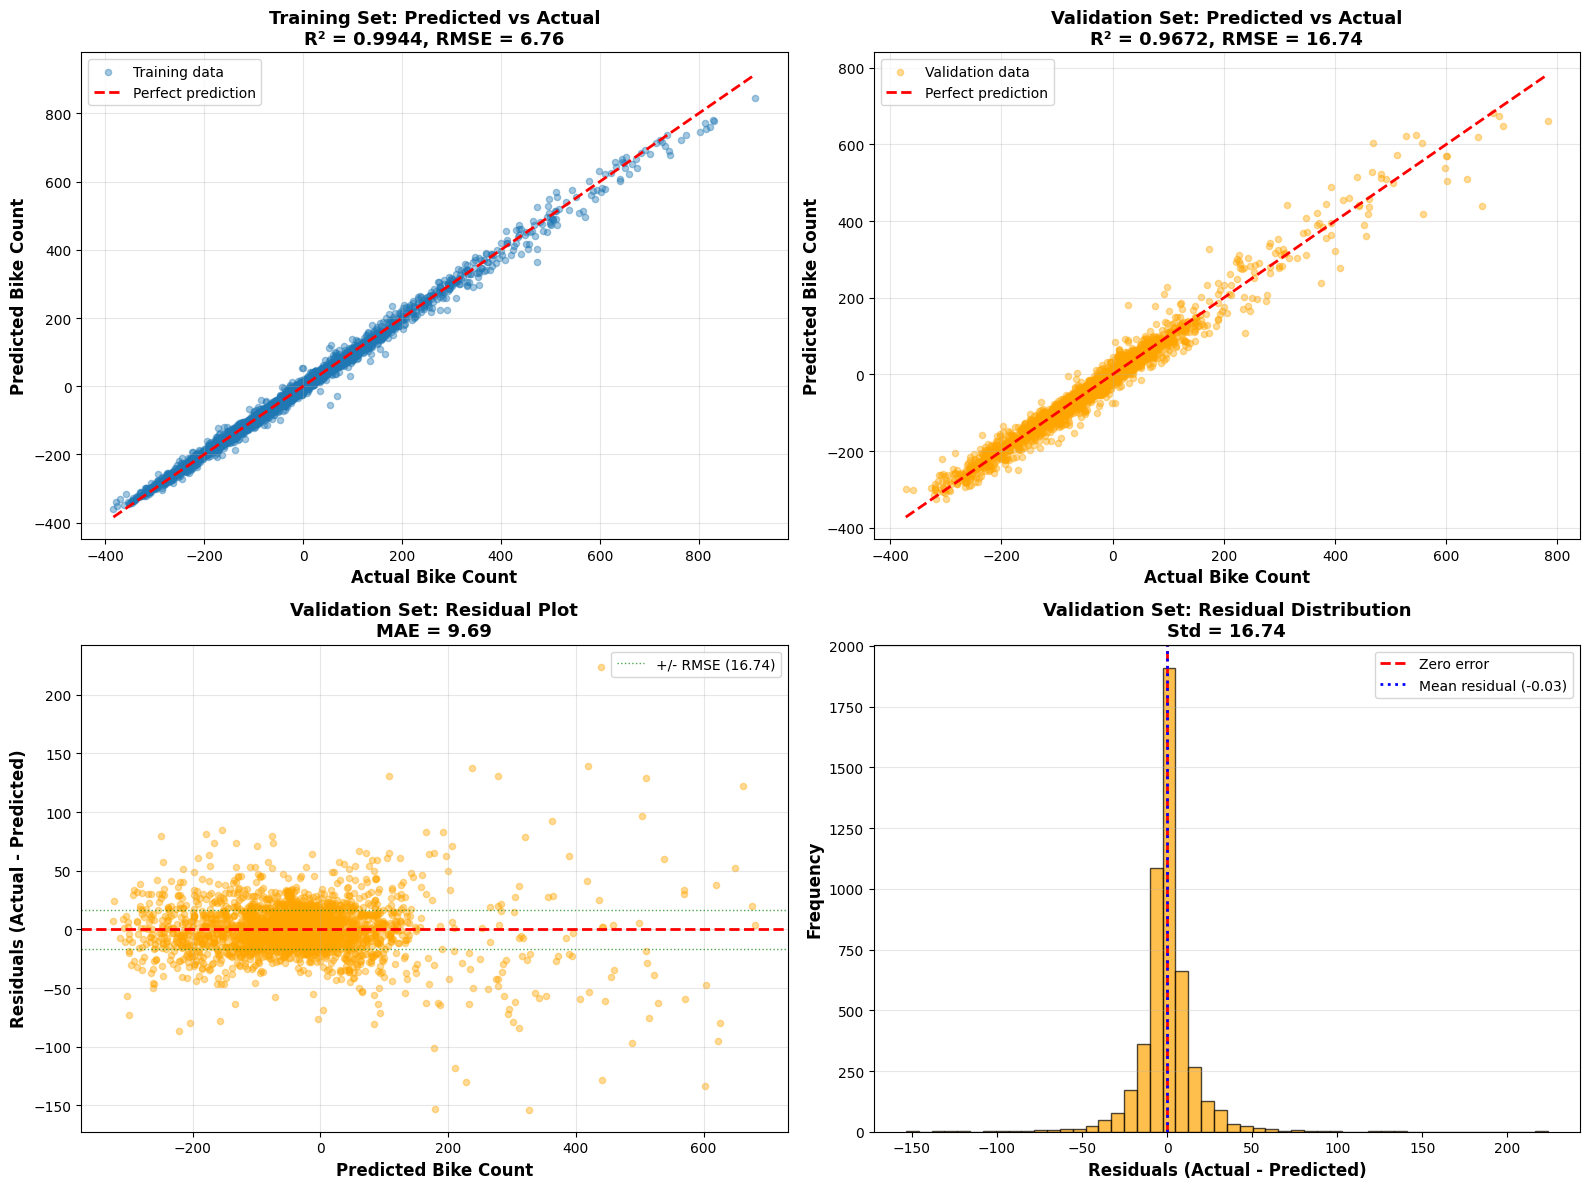

ERROR ANALYSIS SUMMARY - VALIDATION SET

TRAINING SET:
  MAE:  3.80 bikes
  RMSE: 6.76 bikes
  R²:   0.9944

VALIDATION SET:
  MAE:  9.69 bikes
  RMSE: 16.74 bikes
  R²:   0.9672

OVERFITTING GAP:
  Train-Val RMSE difference: -9.98 bikes

RESIDUAL STATISTICS (VALIDATION SET):
  Mean residual:    -0.03 bikes
  Std of residuals: 16.74 bikes
  Min residual:     -153.51 bikes
  Max residual:     223.83 bikes

BIAS CHECK:
  ✓ No systematic bias (mean ≈ 0)

HETEROSCEDASTICITY CHECK:
  Examine the residual plot - residuals should be randomly scattered around zero
  with consistent variance across all prediction ranges.


In [56]:
print("\n" + "="*70)
print("RUNNING ERROR ANALYSIS ON VALIDATION SET")
print("="*70)
results_analysis = error_analysis(
    rf_final,
    X_train_cluster,
    y_train_cluster,
    X_val_cluster,
    y_val_cluster,
    dataset_name="Validation"
)

### Plot Learning Curve on Validation Set

LEARNING CURVE ANALYSIS

Training models with different training set sizes...
Total models to train: 10
----------------------------------------------------------------------
[ 1/10] Size:  10.0% ( 1495 samples) | Train RMSE:   8.80 | Val RMSE:  25.95 | Time:  5.2s
[ 2/10] Size:  20.0% ( 2991 samples) | Train RMSE:   8.75 | Val RMSE:  21.73 | Time:  6.9s
[ 3/10] Size:  30.0% ( 4487 samples) | Train RMSE:   7.80 | Val RMSE:  19.71 | Time: 12.6s
[ 4/10] Size:  40.0% ( 5983 samples) | Train RMSE:   7.52 | Val RMSE:  19.67 | Time: 18.5s
[ 5/10] Size:  50.0% ( 7479 samples) | Train RMSE:   7.33 | Val RMSE:  18.49 | Time: 20.9s
[ 6/10] Size:  60.0% ( 8974 samples) | Train RMSE:   7.30 | Val RMSE:  18.19 | Time: 31.3s
[ 7/10] Size:  70.0% (10470 samples) | Train RMSE:   7.30 | Val RMSE:  17.81 | Time: 29.0s
[ 8/10] Size:  80.0% (11966 samples) | Train RMSE:   7.01 | Val RMSE:  17.29 | Time: 33.4s
[ 9/10] Size:  90.0% (13462 samples) | Train RMSE:   6.88 | Val RMSE:  17.12 | Time: 38.1s
[10/10

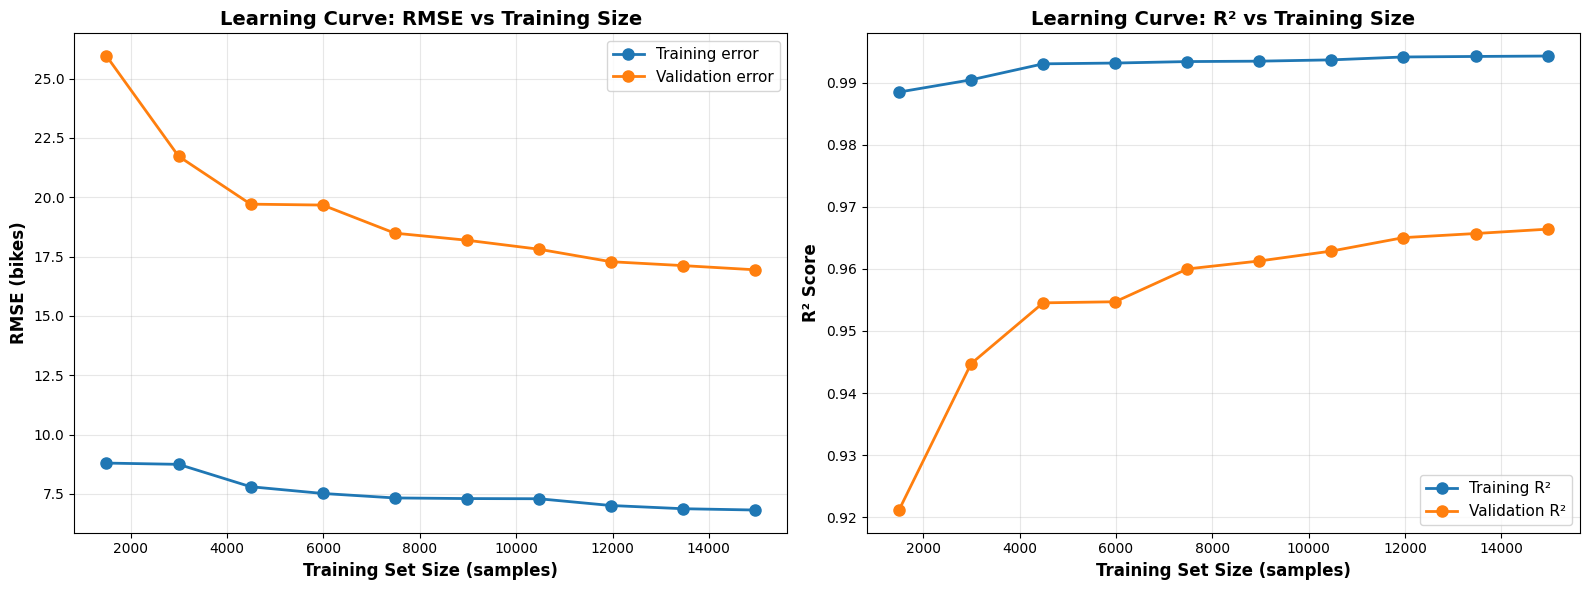

LEARNING CURVE INTERPRETATION

Final performance (100% training data):
  Training RMSE:   6.82 bikes
  Validation RMSE: 16.95 bikes
  Train-Val gap:   -10.12 bikes

Improvement in last 30% of data: 0.34 bikes

○ OBSERVATION: Validation error slightly decreasing
  → Model might benefit from a bit more data, but gains are diminishing

✓ WELL-BALANCED MODEL:
  → Good balance between bias and variance
  → Training and validation errors are close



In [60]:
print("="*70)
print("LEARNING CURVE ANALYSIS")
print("="*70)

# Define training set sizes to test (from 10% to 100%)
train_sizes = np.linspace(0.1, 1.0, 10)
train_scores = []
val_scores = []
train_r2_scores = []
val_r2_scores = []

start_time = time.time()

print(f"\nTraining models with different training set sizes...")
print(f"Total models to train: {len(train_sizes)}")
print("-"*70)

for idx, train_size in enumerate(train_sizes, 1):
    iter_start = time.time()

    # Sample training data
    n_samples = int(len(X_train_cluster) * train_size)
    indices = np.random.choice(len(X_train_cluster), n_samples, replace=False)

    # Use .iloc for pandas DataFrames/Series
    X_train_subset = X_train_cluster.iloc[indices]
    y_train_subset = y_train_cluster.iloc[indices]

    # Train model on subset
    rf_temp = RandomForestRegressor(**best_params_final, random_state=42)
    rf_temp.fit(X_train_subset, y_train_subset)

    # Evaluate on training subset and validation set
    y_train_pred = rf_temp.predict(X_train_subset)
    y_val_pred = rf_temp.predict(X_val_cluster)

    train_rmse = np.sqrt(mean_squared_error(y_train_subset, y_train_pred))
    val_rmse = np.sqrt(mean_squared_error(y_val_cluster, y_val_pred))

    train_r2 = r2_score(y_train_subset, y_train_pred)
    val_r2 = r2_score(y_val_cluster, y_val_pred)

    train_scores.append(train_rmse)
    val_scores.append(val_rmse)
    train_r2_scores.append(train_r2)
    val_r2_scores.append(val_r2)

    iter_time = time.time() - iter_start

    print(f"[{idx:2d}/10] Size: {train_size*100:5.1f}% ({n_samples:5d} samples) | "
          f"Train RMSE: {train_rmse:6.2f} | Val RMSE: {val_rmse:6.2f} | "
          f"Time: {iter_time:4.1f}s")

total_time = time.time() - start_time
print("-"*70)
print(f"✓ Completed in {total_time:.1f} seconds ({total_time/60:.2f} minutes)\n")

# Convert to arrays for plotting
train_sizes_samples = (train_sizes * len(X_train_cluster)).astype(int)
train_scores = np.array(train_scores)
val_scores = np.array(val_scores)
train_r2_scores = np.array(train_r2_scores)
val_r2_scores = np.array(val_r2_scores)

# Create learning curve plots
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Plot 1: RMSE Learning Curve
ax1 = axes[0]
ax1.plot(train_sizes_samples, train_scores, 'o-', label='Training error',
         linewidth=2, markersize=8)
ax1.plot(train_sizes_samples, val_scores, 'o-', label='Validation error',
         linewidth=2, markersize=8)
ax1.set_xlabel('Training Set Size (samples)', fontsize=12, fontweight='bold')
ax1.set_ylabel('RMSE (bikes)', fontsize=12, fontweight='bold')
ax1.set_title('Learning Curve: RMSE vs Training Size', fontsize=14, fontweight='bold')
ax1.legend(fontsize=11)
ax1.grid(True, alpha=0.3)

# Plot 2: R² Learning Curve
ax2 = axes[1]
ax2.plot(train_sizes_samples, train_r2_scores, 'o-', label='Training R²',
         linewidth=2, markersize=8)
ax2.plot(train_sizes_samples, val_r2_scores, 'o-', label='Validation R²',
         linewidth=2, markersize=8)
ax2.set_xlabel('Training Set Size (samples)', fontsize=12, fontweight='bold')
ax2.set_ylabel('R² Score', fontsize=12, fontweight='bold')
ax2.set_title('Learning Curve: R² vs Training Size', fontsize=14, fontweight='bold')
ax2.legend(fontsize=11)
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('learning_curve_analysis.png', dpi=300, bbox_inches='tight')
plt.show()

# Analysis and interpretation
print("="*70)
print("LEARNING CURVE INTERPRETATION")
print("="*70)

final_train_rmse = train_scores[-1]
final_val_rmse = val_scores[-1]
gap = final_train_rmse - final_val_rmse

print(f"\nFinal performance (100% training data):")
print(f"  Training RMSE:   {final_train_rmse:.2f} bikes")
print(f"  Validation RMSE: {final_val_rmse:.2f} bikes")
print(f"  Train-Val gap:   {gap:.2f} bikes")

# Check if validation curve is still improving
improvement_last_30 = val_scores[-3] - val_scores[-1]
print(f"\nImprovement in last 30% of data: {improvement_last_30:.2f} bikes")

if improvement_last_30 > 1.0:
    print("\n✓ OBSERVATION: Validation error still decreasing significantly")
    print("  → Model would likely benefit from MORE training data")
elif improvement_last_30 > 0.2:
    print("\n○ OBSERVATION: Validation error slightly decreasing")
    print("  → Model might benefit from a bit more data, but gains are diminishing")
else:
    print("\n✓ OBSERVATION: Validation error has plateaued")
    print("  → Model has sufficient training data - more data won't help much")

# Check for high bias vs high variance
if gap < -20:  # Training error much higher than validation
    print("\n⚠ HIGH BIAS DETECTED:")
    print("  → Model is underfitting - both training and validation errors are high")
    print("  → Try: more complex model, more features, or less regularization")
elif abs(gap) < 20:
    print("\n✓ WELL-BALANCED MODEL:")
    print("  → Good balance between bias and variance")
    print("  → Training and validation errors are close")
else:
    print("\n⚠ HIGH VARIANCE DETECTED:")
    print("  → Model is overfitting - large gap between train and validation")
    print("  → Try: more data, regularization, or simpler model")

print("\n" + "="*70)

## Final Evaluation of Best RF Model on Test Set

In [57]:
print("="*70)
print("FINAL MODEL EVALUATION ON TEST SET")
print("="*70)

# Make predictions on test set
y_test_pred = rf_final.predict(X_test_cluster)

# Calculate test metrics
test_mae = mean_absolute_error(y_test_cluster, y_test_pred)
test_rmse = np.sqrt(mean_squared_error(y_test_cluster, y_test_pred))
test_r2 = r2_score(y_test_cluster, y_test_pred)

# Also get training and validation metrics for comparison
y_train_pred = rf_final.predict(X_train_cluster)
y_val_pred = rf_final.predict(X_val_cluster)

train_mae = mean_absolute_error(y_train_cluster, y_train_pred)
train_rmse = np.sqrt(mean_squared_error(y_train_cluster, y_train_pred))
train_r2 = r2_score(y_train_cluster, y_train_pred)

val_mae = mean_absolute_error(y_val_cluster, y_val_pred)
val_rmse = np.sqrt(mean_squared_error(y_val_cluster, y_val_pred))
val_r2 = r2_score(y_val_cluster, y_val_pred)

# Print comprehensive comparison
print("\n" + "="*70)
print("PERFORMANCE COMPARISON: TRAIN / VALIDATION / TEST")
print("="*70)

print(f"\n{'Metric':<15} {'Training':<15} {'Validation':<15} {'Test':<15}")
print("-"*70)
print(f"{'MAE (bikes)':<15} {train_mae:<15.2f} {val_mae:<15.2f} {test_mae:<15.2f}")
print(f"{'RMSE (bikes)':<15} {train_rmse:<15.2f} {val_rmse:<15.2f} {test_rmse:<15.2f}")
print(f"{'R²':<15} {train_r2:<15.4f} {val_r2:<15.4f} {test_r2:<15.4f}")

# Calculate differences
print("\n" + "="*70)
print("GENERALIZATION ANALYSIS")
print("="*70)

train_test_rmse_gap = train_rmse - test_rmse
val_test_rmse_gap = val_rmse - test_rmse

print(f"\nTrain-Test RMSE gap:      {train_test_rmse_gap:+.2f} bikes")
print(f"Validation-Test RMSE gap: {val_test_rmse_gap:+.2f} bikes")

if abs(val_test_rmse_gap) < 1.0:
    print("\n✓ EXCELLENT: Test performance matches validation - model generalizes well!")
elif abs(val_test_rmse_gap) < 2.0:
    print("\n✓ GOOD: Test performance is close to validation - model generalizes reasonably well")
else:
    print("\n⚠ WARNING: Significant gap between validation and test - possible data shift or overfitting")

print("\n" + "="*70)
print("FINAL TEST SET RESULTS")
print("="*70)
print(f"Samples:     {len(y_test_cluster):,}")
print(f"MAE:         {test_mae:.2f} bikes")
print(f"RMSE:        {test_rmse:.2f} bikes")
print(f"R²:          {test_r2:.4f}")
print(f"Mean target: {y_test_cluster.mean():.2f} bikes")
print(f"RMSE/Mean:   {(test_rmse/y_test_cluster.mean())*100:.2f}%")

# Save predictions for further analysis
print("\n" + "="*70)
print("SAVING TEST PREDICTIONS")
print("="*70)

import pandas as pd

test_results = pd.DataFrame({
    'actual': y_test_cluster,
    'predicted': y_test_pred,
    'residual': y_test_cluster - y_test_pred,
    'abs_error': np.abs(y_test_cluster - y_test_pred)
})

# Show some sample predictions
print("\nSample predictions:")
print(test_results.head(10).to_string(index=False))

# Identify worst predictions
print("\n" + "="*70)
print("WORST PREDICTIONS (Top 5)")
print("="*70)
worst_predictions = test_results.nlargest(5, 'abs_error')
print(worst_predictions.to_string(index=False))

FINAL MODEL EVALUATION ON TEST SET

PERFORMANCE COMPARISON: TRAIN / VALIDATION / TEST

Metric          Training        Validation      Test           
----------------------------------------------------------------------
MAE (bikes)     3.80            9.69            9.81           
RMSE (bikes)    6.76            16.74           17.95          
R²              0.9944          0.9672          0.9619         

GENERALIZATION ANALYSIS

Train-Test RMSE gap:      -11.18 bikes
Validation-Test RMSE gap: -1.21 bikes

✓ GOOD: Test performance is close to validation - model generalizes reasonably well

FINAL TEST SET RESULTS
Samples:     4,987
MAE:         9.81 bikes
RMSE:        17.95 bikes
R²:          0.9619
Mean target: -23.53 bikes
RMSE/Mean:   -76.28%

SAVING TEST PREDICTIONS

Sample predictions:
 actual   predicted   residual  abs_error
     -4   -3.170013  -0.829987   0.829987
   -126 -132.733333   6.733333   6.733333
   -158 -157.806667  -0.193333   0.193333
    -45  -47.497892   2.4


RUNNING COMPREHENSIVE ERROR ANALYSIS ON TEST SET


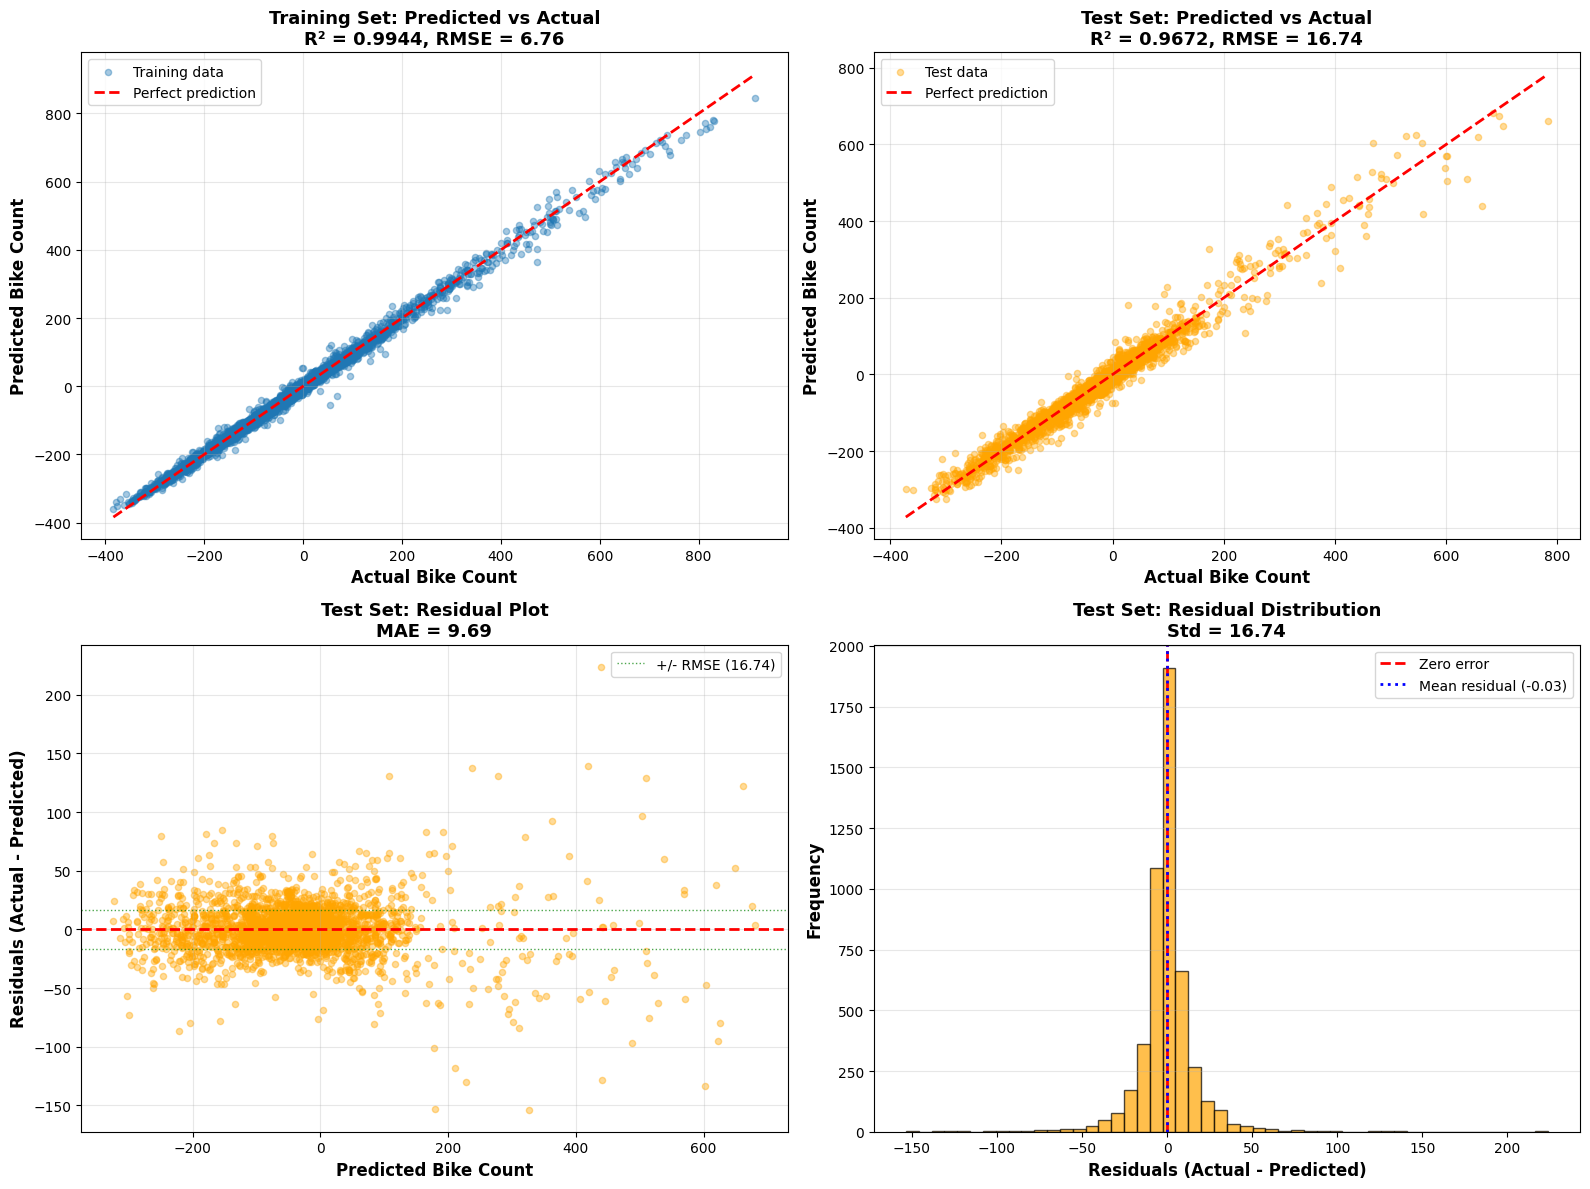

ERROR ANALYSIS SUMMARY - TEST SET

TRAINING SET:
  MAE:  3.80 bikes
  RMSE: 6.76 bikes
  R²:   0.9944

TEST SET:
  MAE:  9.69 bikes
  RMSE: 16.74 bikes
  R²:   0.9672

OVERFITTING GAP:
  Train-Val RMSE difference: -9.98 bikes

RESIDUAL STATISTICS (TEST SET):
  Mean residual:    -0.03 bikes
  Std of residuals: 16.74 bikes
  Min residual:     -153.51 bikes
  Max residual:     223.83 bikes

BIAS CHECK:
  ✓ No systematic bias (mean ≈ 0)

HETEROSCEDASTICITY CHECK:
  Examine the residual plot - residuals should be randomly scattered around zero
  with consistent variance across all prediction ranges.


In [58]:
# Full error analysis on test set
print("\n" + "="*70)
print("RUNNING COMPREHENSIVE ERROR ANALYSIS ON TEST SET")
print("="*70)

results_test = error_analysis(
    rf_final,
    X_train_cluster,
    y_train_cluster,
    X_test_cluster,
    y_test_cluster,
    dataset_name="Test"
)
